# Algoritmo Genético
Esse projeto tem o objetivo de utilizar algoritmos evolutivos para criar um agente que consiga jogar e vencer uma partida de pacman.
Nossa ideia inicial de algoritmo evolutivo foi gerar uma sequência de ações para o pacman seguir e percorrer o labirinto proposto, gerando um vetor que guardaria a sequência de ações que deveria ser tomada pelo indivíduo, porém, esta ideia não se provou muito apropriada, pois a natureza dos outros agentes (fantasmas) é não determinística, inviabilizando a ideia inicial.
Assim, nos inspiramos no paper de Brandstetter e Ahmadi para implementar um algoritmo genético baseado em árvores genéticas, possibilitando ao agente tomar decisões baseado nos estados do jogo e não mais apenas no percurso. Também utilizamos do paper o princípio de tomar ações simples e direcionais apenas, não dependendo de definir estratégias mais complexas e subjetivas ao jogo, como também da adoção de constantes para os cálculos. No entanto, adotamos menos variáveis dos estados para definir a movimentação do pacman, simplificando ou ignorando algumas adotadas pelos autores.


Parametros:
 - Tam da população
 - Num gerações
 - Taxa de mutação
 - Num de mutação por geração
 - Profundidade da arvore inicial
 - Num de treinos p/ ind
 - Num de Ind p/ torneio

### Fitnes Function:
Para calcularmos a função de fitness para cada indivíduo utilizamos prontamente o valor de média dos scores finais de cada partida realizada por esse ao final da quantidade de partidas estipuladas.

### População Inicial
Iniciamos uma primeira geração com um número N de indivíduos gerados aleatóriamente com uma altura máxima inicial pré estabelecida de 4. Escolhemos esta quantidade inicial de indivíduos pois nos pareceu uma quantidade razoável dada nossa capacidade computacional e tempo disponíveis para a realização dos treinos, garantindo certa variabilidade aos indivíduos, assim como também a altura da árvore, que nos garante variabilidade e também complexidade comportamental a estes.  

### Técnica de seleção
Como técnica de seleção para o pais dos indivíduos da próxima geração utilizamos a técnica de torneio. implementamos o torneio selecionando um número aleatório de indivíduos determinado por um parametro, e escolhemos o indíviduo com o maior fitness (score final). 

### Crossover
Para função de crossover da população, selecionamos dois indivíduos por meio do torneio e a partir destes criamos dois novos filhos, repetindo isso até que tenhamos completado o número de indivíduos menos dois da próxima geração. 
O crossover propriamente dito se dá pela função scan_tree, que percorre cada uma das árvores buscando por algum nó aleatório e então os troca, gerando os novos filhos a partir dessa combinação.

### Mutação
O processo de mutação se dá pela escolha de um número determinado por um parâmetro dentre os filhos da população atual, que poderão ter algum de seus nós aleatoriamente substituídos por uma nova sub-árvore a depender de uma taxa de mutação pré estipulada, alterando ou gerando novos genes nos indivíduos.

### Nova População
A nova população será composta pelos filhos gerados através do crossover e os dois indivídos com maior fitness da população anterior (elitismo).

## Biblioteca
Para a implementação do algoritmo evolutivo utilizamos uma estrutura de árvores genéticas a partir do algoritmo encontrado em [ttps://github.com/moshesipper/tiny_gp], com algumas pequenas alterações, além de também usar de referência o artigo Reactive Control of Ms. Pac Man using Information Retrieval based on Genetic Programming de Brandstetter e Ahmadi.
Mantemos da biblioteca a classe GPTree, com seus métodos básicos, fazendo alterações na mutação e na computação dos nós da árvore a partir dos terminais (bottom-up), e semelhantemente ao artigo, buscamos calcular atomicamente as próximas ações a partir dos estados atuais.
Essa biblioteca nos chamou a atenção pela implementação do método random_tree, pois este método gera árvores genéticas aleatoriamente atribuindo as funções aos nós intermediários e os terminais aos nós folhas ( muito útil na inicialização e mutação dos indivíduos). Além desse método, o método scan_tree também nos pareceu muito interessante, pois este é muito útil para o crossover (seleção e troca dos genes).

### Funções
As funções são as operações executadas nos nós da árvore (add, sub e mul).

### Terminais
Os terminais são os tipos possíveis de nós folha, determinados pelas variáveis de estado e por constantes para possibilitar a associação de pesos às variáveis de estado.
Decidimos calcular terminais a partir, basicamente, da posição atual do pacman, posição e score futuros do pacman, distância aos fantasmas (comestível ou não), às pílulas e à comida, além de se haverá encontro com alguma comida ou ao fantasma.




In [1]:
from search import *
from game import *
from util import *
from pacman import *
import util, layout
import sys, types, time, random, os
import numpy as np
from random import random, randint, seed, choice

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [20]:
# tiny genetic programming by © moshe sipper, www.moshesipper.com

from statistics import mean
from copy import deepcopy

def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y

FUNCTIONS = [add, sub, mul]
TERMINALS = ['actionScore', 
             'eatFood', 
             'minGhostDist', 
             'minDistToFood', 
             'distToPill', 
             'minDistEdibleGhost', 
             'encounterGhost',
             -1.0, 0.5, 1.0, 2.0] # 0.0,  -0.5,

STATE_VARS = ['actionScore', 
              'eatFood', 
              'minGhostDist', 
              'minDistToFood', 
              'distToPill', 
              'minDistEdibleGhost', 
              'encounterGhost']
" actionScore: scoreFuturo - scoreAtual "
" eatFood: numFoodAtual - numFoodFuturo"
" minGhostDist: |ghostX - pacmanX| + |ghostY - pacmanY| "
" minDistToFood: |foodX - pacmanX| + |foodY - pacmanY| "
" distToPill: |pillX - pacmanX| + |pillY - pacmanY| "


class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right
        
    def setLeft(self, tree):
        self.left = tree
        
    def setRight(self, tree):
        self.right = tree
        
    def node_label(self): # string label
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else: 
            return str(self.data)
    
    def print_tree(self, prefix = ""): # textual printout
        print("%s%s" % (prefix, self.node_label()))        
        if self.left:  self.left.print_tree (prefix + "   ")
        if self.right: self.right.print_tree(prefix + "   ")

    def computeTree(self, stateVars): 
        if (self.data in FUNCTIONS): 
            return self.data(self.left.computeTree(stateVars), self.right.computeTree(stateVars))
        elif (self.data in STATE_VARS): 
            return stateVars[self.data]
        else: return self.data
        
    def size(self): # tree size in nodes
        if self.data in TERMINALS: return 1
        l = self.left.size()  if self.left  else 0
        r = self.right.size() if self.right else 0
        return 1 + l + r
    
    def random_tree(self, grow, max_depth, depth = 0): # create random tree using either grow or full method
        if depth < MIN_DEPTH or (depth < max_depth and not grow): 
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        elif depth >= max_depth:   
            self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
        else: # intermediate depth, grow
            if random () > 0.5: 
                self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        if self.data in FUNCTIONS:
            self.left = GPTree()          
            self.left.random_tree(grow, max_depth, depth = depth + 1)            
            self.right = GPTree()
            self.right.random_tree(grow, max_depth, depth = depth + 1)
            
    def getSubtree(self):
        t = GPTree()
        t.data = self.data
        if self.left:  t.left  = self.left.getSubtree()
        if self.right: t.right = self.right.getSubtree()
        return t
    
    def scan_tree(self, count, second): # note: count is list, so it's passed "by reference"
        count[0] -= 1            
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.getSubtree()
            else: # glue subtree here
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:  
            ret = None
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)  
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)
            return ret
        
    def mutation(self, probability=0.3):
        if random() < probability: # mutate at this node
            self.random_tree(grow = True, max_depth= 2)
        else:
            if random() < 0.5:
                if self.left: self.left.mutation(probability)
                elif self.right: self.right.mutation(probability)
            else:
                if self.right: self.right.mutation(probability)
                elif self.left: self.left.mutation(probability)
        

In [3]:
tree = GPTree()
tree.random_tree(True, 2)
tree.print_tree()
thisdict = {
    STATE_VARS[0]: 1.0,
    STATE_VARS[1]: 2.0,
    STATE_VARS[2]: 3.0,
    STATE_VARS[3]: 4.0,
    STATE_VARS[4]: 5.0,
    STATE_VARS[5]: 6.0,
    STATE_VARS[6]: 7.0
}
print(tree.computeTree(thisdict))

sub
   add
      0.5
      eatFood
   add
      -1.0
      eatFood
1.5


In [4]:
" Criar populacao inicial"
''' Para a criação da população inicial, utilizamos o método RandomTree() que gera árvores randomicamente dentro 
    do domínio de operações fundamentais (add, sub, mul) 
        e dos terminais definidos (variaveis de estado e constantes)
'''

' Para a criação da população inicial, utilizamos o método RandomTree() que gera árvores randomicamente dentro \n    do domínio de operações fundamentais (add, sub, mul) \n        e dos terminais definidos (variaveis de estado e constantes)\n'

In [5]:

def initialPopulation(populationSize=32,treeDepth=3):
    population = []
    for _ in range(populationSize):
        tree = GPTree()
        tree.random_tree(True, treeDepth)
        population.append(tree)
    return population

In [18]:
" FITNESS "

# stateVars -> dictionary  ex stateVars['distX'] = distXGameStateVariable
def getFitness(individuo, gen):
    return trainIndividual(individuo, gen)

def getPopFitness(population, gen):
    return [getFitness(population[i], gen) for i in range(0,len(population))]

    
    

" SELEÇÂO "
'''Para algotimo de seleção, adotaremos inicialmente o método de seleção por Torneio, na ideia de
    aumentar as randomicidade do modelo.
'''
def tournament(population, fitness, size):
    indexes = np.random.choice(range(0,len(population)),size,False)
    chosen = [fitness[i] for i in indexes]
    return population[indexes[chosen.index(max(chosen))]]

def getParent(population, fitness,size=4):
    return tournament(population, fitness, size)


" CROSSOVER "
''' Para a reprodução dos pais, utilizamos uma função de crossover para árvores, 
'''

def crossover(treeA, treeB): # xo 2 trees at random nodes
    child1 = treeA.getSubtree()
    child2 = treeB.getSubtree()
    
    geneA = child1.scan_tree([randint(1, treeA.size())], None) # 1st random subtree
    geneB = child2.scan_tree([randint(1, treeB.size())], None) # 2nd random subtree
    child1.scan_tree([randint(1, treeA.size())], geneB) # 2nd subtree "glued" inside 1st tree
    child2.scan_tree([randint(1, treeB.size())], geneA) # 1st subtree "glued" inside 2nd tree
    
    return child1, child2
    
            
" Loop de Reproducao"


' Loop de Reproducao'

In [7]:
tree = GPTree()
tree.random_tree(True, 3)
tree.print_tree()

tree2 = GPTree()
tree2.random_tree(True, 3)
tree2.print_tree()

c1, c2 = crossover(tree, tree2)
c1.print_tree()
c2.print_tree()

add
   mul
      encounterGhost
      -1.0
   add
      2.0
      sub
         minDistEdibleGhost
         distToPill
sub
   sub
      eatFood
      sub
         minGhostDist
         -1.0
   sub
      mul
         1.0
         minDistEdibleGhost
      minDistToFood
add
   mul
      encounterGhost
      -1.0
   add
      2.0
      sub
         eatFood
         sub
            minGhostDist
            -1.0
sub
   sub
      eatFood
      sub
         minGhostDist
         -1.0
   add
      mul
         encounterGhost
         -1.0
      add
         2.0
         sub
            minDistEdibleGhost
            distToPill


In [13]:
n = Directions.NORTH
s = Directions.SOUTH
e = Directions.EAST
w = Directions.WEST

def manhattanDistance(posA, posB):
    return (abs(posB[0] - posA[0]) + abs(posB[1] - posA[1]))

def calcMinGhostDist(pacmanPosition, ghostsPosition):
    dist = 99999
    for ghost in ghostsPosition:
        if dist > manhattanDistance(pacmanPosition, ghost):
            dist = manhattanDistance(pacmanPosition, ghost)
            
    return dist

def manhattanFoodDistance(posA, posX, posY):
    return (abs(posX - posA[0]) + abs(posY - posA[1]))

def minDistBFS(agentPos, positions, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if len(positions) > 0:
        while queue:
            el = queue.pop(0)
            h = el[1]
            s = el[0]

            north = (s[0],s[1]+1)
            south = (s[0],s[1]-1)
            west = (s[0]-1,s[1])
            east = (s[0]+1,s[1])

            for i in [north, south, west, east]:    
                if visited[i[0]][i[1]] == False:
                    queue.append((i,h+1))
                    visited[i[0]][i[1]] = True

                    if(i in positions):    
    #                     print (i, end = " ")
                        return h
                
    return 0

def findFoodMinDistBFS(agentPos, foodGrid, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True

    while queue:
        el = queue.pop(0)
        h = el[1]
        s = el[0]

        north = (s[0],s[1]+1)
        south = (s[0],s[1]-1)
        west = (s[0]-1,s[1])
        east = (s[0]+1,s[1])

        for i in [north, south, west, east]:    
            if visited[i[0]][i[1]] == False:
                queue.append((i,h+1))
                visited[i[0]][i[1]] = True

                if(foodGrid[i[0]][i[1]]):    
#                     print (i, end = " ")
                    return h
                
    return 0

def getMinDistEdibleGhost(agentPos,state):
    ghostPos = []
    ghostStates = state.getGhostStates()
    for gs in ghostStates:
        if gs.scaredTimer > 0:
            ghostPos.append(gs.getPosition())
            
    return minDistBFS(agentPos, ghostPos, state.getWalls())


def calcMinFoodDist(pacmanPosition, foodGrid):
    dist = 99999
    for i in range(1,len(foodGrid[:])-1):
        for j in range(1,len(foodGrid[0][:])-1):
            if foodGrid[i][j] and (dist > manhattanFoodDistance(pacmanPosition, i, j)):
                dist = manhattanFoodDistance(pacmanPosition, i, j)

    return dist

def calcMinPillDist(pacmanPosition, pills):
    return calcMinGhostDist(pacmanPosition, pills)

class MyGoWestAgent(Agent):
    "An agent that goes West until it can't."
    def __init__(self, tree = None):
        self.tree = tree
        
    def setTree(self, tree):
        selt.tree = tree

    def getAction(self, state):
        "The agent receives a GameState (defined in pacman.py)."
#         print(state.getLegalPacmanActions())
#         print(state.getPacmanState())

#         print(state.getPacmanPosition())
#         print(state.getNumFood())
#         print(state.getScore())
        count = 0
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP) #remove a opcao Stop
        actionScore = []
        stateVars = {}
        for action in legalActions:
            
            futureState = state.generatePacmanSuccessor(action)
            
            future_pos = futureState.getPacmanPosition()
            
            futureScore = futureState.getScore() - state.getScore()
            eatFood = state.getNumFood() - futureState.getNumFood()
            
            ghostDist = minDistBFS(future_pos, futureState.getGhostPositions(), state.getWalls())
            foodDist = findFoodMinDistBFS(future_pos,state.getFood(),state.getWalls())
            pillDist = minDistBFS(future_pos, state.getCapsules(), state.getWalls())
            edibleGhost = getMinDistEdibleGhost(future_pos,futureState)
            if ghostDist == 1:
                encounterGhost = 1
            else:
                encounterGhost = 0
            
            stateVars[STATE_VARS[0]] = futureScore
            stateVars[STATE_VARS[1]] = eatFood
            stateVars[STATE_VARS[2]] = ghostDist
            stateVars[STATE_VARS[3]] = foodDist
            stateVars[STATE_VARS[4]] = pillDist
            stateVars[STATE_VARS[5]] = edibleGhost
            stateVars[STATE_VARS[6]] = encounterGhost

            treeValue = tree.computeTree(stateVars)
            actionScore.append(treeValue)
            
        
        maxScore = max(actionScore)
        if actionScore.count(maxScore) > 1:
            indexes = [i for i, j in enumerate(actionScore) if j == maxScore]
            maxIndex = choice(indexes)
        else:
            maxIndex = actionScore.index(maxScore)
            
        
        
        action = legalActions[maxIndex]
        # print("Action Score: ",actionScore)
        
#         print("Action: ",action)
#         futureState = state.generatePacmanSuccessor(action)
#         futureScore = futureState.getScore() - state.getScore()
#         eatFood = state.getNumFood() - futureState.getNumFood()
#         ghostDist = calcMinGhostDist(futureState.getPacmanPosition(),futureState.getGhostPositions())
#         foodDist = calcMinFoodDist(futureState.getPacmanPosition(),futureState.getFood())
#         print("STATE VARS: FS: ", futureScore," EF: ", eatFood, " GD: ", ghostDist," FD: ", foodDist, " PD: ", pillDist)
        
        if action in state.getLegalPacmanActions():
            return action
        else:
            return Directions.STOP

In [9]:
import graphicsDisplay

gen_atual = 1
winsDict = {}

def trainIndividual(ind, gen, layoutType='smallClassic', numGames=5):
    gameLayout = layout.getLayout( 'smallClassic' )
    print("------------------------------------------ train --------------------")
    ind.print_tree()

    pacman = MyGoWestAgent(ind)

    ghostType = loadAgent('RandomGhost', True)
    ghosts = [ghostType( i+1 ) for i in range( 4 )]

    import textDisplay
    textDisplay.SLEEP_TIME = 0.1
    # gameDisplay = textDisplay.PacmanGraphics()
    gameDisplay = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)

    games = runGames( gameLayout, pacman, ghosts, gameDisplay, numGames, False)
    scores = [game.state.getScore() for game in games]
    wins = [game.state.isWin() for game in games]
    winRate = wins.count(True)/ float(len(wins))
    
    winsDict[str(gen)].append(winRate)
    
    avgScore = sum(scores) / float(len(scores))
    return avgScore

In [2]:
pops = []

def compareTrees(tree1, tree2):
    if (not tree1 and tree2 != None) or (not tree2 and tree1 != None):
        return False
    if tree1.data != tree2.data:
        return False
    if not tree1.data and not tree2.data:
        return True
    return compareTrees(tree1.left, tree2.left) and compareTrees(tree1.right, tree2.right)

def generationLoop():
    population = initialPopulation(POP_SIZE, TREE_SIZE) # popSize, tam GPTree
#     fitness = np.zeros((1,len(population)))
    
    genFits = []
    maxFits = []
    minFits = []
    
    count = 1
    
    winsDict[str(count)] = []
    
    for p in population:
        p.print_tree()
        print(" - - - - ")
    print("G - ",count,"    ============================================  ")
    
    # train population to get fitness
        
    fitness = getPopFitness(population, count)
    print("G",count," - FITNESS: ", fitness )
    pops.append(population)
    while count <= NUM_GEN: # gen
        
        
        children = []
        
        for i in range(0,int(len(population)/2)-1):
            father = getParent(population, fitness,3)
            mother = getParent(population, fitness,3)
            
            # TODO - check if parent == mother
            
            child1, child2 = crossover(father, mother)
            children.append(child1)
            children.append(child2)
            

#       children = mutation(children,int(len(children)*0.75))#mutation
        indexes = np.random.choice(range(0,len(children)),int(len(children)*0.25),False)
        for i in indexes:
            children[i].mutation(0.2)
        
        # elitism
        maxIndex = fitness.index(max(fitness))
        children.append(population[maxIndex])
        
        fitness.remove(max(fitness))
        population.remove(population[maxIndex])
        
        maxIndex = fitness.index(max(fitness))
        children.append(population[maxIndex])
        
        count += 1
        
        winsDict[str(count)] = []
        
        # train population to get fitness
        print("G", count," - POPULATION")
        
        population = children[:]
        for p in population:
            p.print_tree()
            print(" - - - - ")
            
        fitness = getPopFitness(population, count)
        pops.append(population)
        # colocar fitness em um vetor
        #      - Pop
        #      - Max
        #      - Min
        print("FITNESS: ", fitness )
        avgFit = sum(fitness) / float(len(fitness))
        print("Avg: ", avgFit)
        genFits.append(avgFit)
        maxFit = max(fitness)
        print("Max: ", maxFit)
        maxFits.append(maxFit)
        minFit = min(fitness)
        print("Min: ", minFit)
        minFits.append(minFit)
    
    print("gen means: ", genFits)
    print("gen maxes: ", maxFits)
    print("gen mins: ", minFits)
    
    x = np.linspace(1, NUM_GEN, num= NUM_GEN, endpoint=True)
    y1 = np.array(genFits)
    y2 = np.array(maxFits)
    y3 = np.array(minFits)
    
    plt.plot(x, y1, '-', x, y2, '-', x, y3, '-')
    plt.legend(['mean', 'max', 'min'], loc='best')
    plt.show()
    
    return population, fitness

add
   sub
      sub
         sub
            encounterGhost
            minDistToFood
         add
            -1.0
            -1.0
      add
         sub
            0.5
            eatFood
         sub
            distToPill
            1.0
   add
      minDistEdibleGhost
      add
         sub
            minDistToFood
            0.5
         add
            distToPill
            -1.0
 - - - - 
add
   add
      mul
         2.0
         add
            1.0
            distToPill
      sub
         minDistToFood
         add
            eatFood
            actionScore
   add
      minDistToFood
      1.0
 - - - - 
mul
   add
      distToPill
      minGhostDist
   add
      distToPill
      add
         actionScore
         minGhostDist
 - - - - 
mul
   add
      add
         add
            distToPill
            eatFood
         1.0
      eatFood
   mul
      sub
         encounterGhost
         minGhostDist
      add
         add
            minDistToFood
            encounterG

         encounterGhost
         2.0
 - - - - 
sub
   add
      minDistEdibleGhost
      sub
         2.0
         0.5
   add
      add
         minGhostDist
         sub
            0.5
            encounterGhost
      mul
         mul
            -1.0
            actionScore
         0.5
 - - - - 
mul
   add
      sub
         mul
            minGhostDist
            2.0
         minDistEdibleGhost
      mul
         minDistEdibleGhost
         add
            -1.0
            minDistToFood
   add
      minDistEdibleGhost
      encounterGhost
 - - - - 
add
   mul
      add
         encounterGhost
         encounterGhost
      add
         minGhostDist
         minDistEdibleGhost
   sub
      sub
         -1.0
         encounterGhost
      sub
         add
            minGhostDist
            eatFood
         add
            2.0
            0.5
 - - - - 
mul
   sub
      actionScore
      minDistEdibleGhost
   add
      sub
         1.0
         0.5
      encounterGhost
 - - - - 
add


Pacman died! Score: -276
Pacman died! Score: -126
Pacman died! Score: -421
Pacman died! Score: -289
Pacman died! Score: -365
Average Score: -295.4
Scores:        -276.0, -126.0, -421.0, -289.0, -365.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      2.0
      encounterGhost
   sub
      add
         add
            1.0
            encounterGhost
         minDistToFood
      actionScore
Pacman died! Score: -192
Pacman died! Score: -137
Pacman died! Score: -277
Pacman died! Score: -298
Pacman died! Score: -419
Average Score: -264.6
Scores:        -192.0, -137.0, -277.0, -298.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      mul
         minGhostDist
         add
            minGhostDist
            distToPill
      0.5
   m

Average Score: -346.8
Scores:        -421.0, -177.0, -315.0, -375.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      add
         1.0
         distToPill
      encounterGhost
   add
      eatFood
      2.0
Pacman died! Score: -289
Pacman died! Score: -428
Pacman died! Score: -227
Pacman died! Score: -411
Pacman died! Score: -222
Average Score: -315.4
Scores:        -289.0, -428.0, -227.0, -411.0, -222.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      minDistEdibleGhost
      mul
         add
            actionScore
            -1.0
         add
            eatFood
            eatFood
   mul
      mul
         mul
            2.0
            minDistToFood
         mul
            1.0
            minDistToFood
      add
   

Pacman died! Score: -248
Pacman died! Score: -329
Pacman died! Score: -427
Pacman died! Score: -367
Pacman died! Score: -419
Average Score: -358.0
Scores:        -248.0, -329.0, -427.0, -367.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      distToPill
      1.0
   sub
      add
         mul
            encounterGhost
            1.0
         mul
            minDistToFood
            2.0
      sub
         encounterGhost
         2.0
Pacman died! Score: -446
Pacman died! Score: -359
Pacman died! Score: -193
Pacman died! Score: -437
Pacman emerges victorious! Score: 942
Average Score: -98.6
Scores:        -446.0, -359.0, -193.0, -437.0, 942.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Loss, Win
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      minDistEdibleGhost
      sub
     

Pacman died! Score: -142
Pacman died! Score: 26
Pacman died! Score: -178
Pacman died! Score: -361
Pacman died! Score: -437
Average Score: -218.4
Scores:        -142.0, 26.0, -178.0, -361.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      minGhostDist
      minDistToFood
   add
      -1.0
      encounterGhost
Pacman died! Score: -383
Pacman died! Score: -249
Pacman died! Score: -420
Pacman died! Score: -241
Pacman died! Score: -437
Average Score: -346.0
Scores:        -383.0, -249.0, -420.0, -241.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      minDistEdibleGhost
      sub
         2.0
         0.5
   add
      add
         minGhostDist
         sub
            mul
               minDistEdibleGhost
               

Pacman died! Score: -437
Pacman died! Score: -437
Pacman died! Score: -446
Pacman died! Score: -424
Average Score: -381.4
Scores:        -163.0, -437.0, -437.0, -446.0, -424.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      eatFood
      2.0
   mul
      minDistToFood
      minDistEdibleGhost
Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -419
Pacman died! Score: -428
Pacman died! Score: -420
Average Score: -428.2
Scores:        -428.0, -446.0, -419.0, -428.0, -420.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         minDistToFood
         distToPill
      sub
         -1.0
         actionScore
   sub
      add
         minGhostDist
         eatFood
      add
         2.0
         0.5
Pacman died

Pacman died! Score: -206
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -157
Pacman died! Score: -446
Average Score: -334.8
Scores:        -206.0, -419.0, -446.0, -157.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      mul
         sub
            actionScore
            eatFood
         mul
            -1.0
            1.0
      sub
         1.0
         -1.0
   sub
      sub
         add
            sub
               2.0
               eatFood
            minGhostDist
         actionScore
      add
         mul
            1.0
            1.0
         mul
            2.0
            0.5
Pacman died! Score: -110
Pacman died! Score: -290
Pacman died! Score: -426
Pacman died! Score: -419
Pacman died! Score: -403
Average Score: -329.6
Scores:        -110.0, -290.0, -426.0, -419.0, -403.0
Win Rate:      0/5 (0.00)
Record:        

Pacman died! Score: -428
Pacman died! Score: -240
Pacman died! Score: -392
Pacman died! Score: -363
Pacman died! Score: -446
Average Score: -373.8
Scores:        -428.0, -240.0, -392.0, -363.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      0.5
      actionScore
   add
      1.0
      -1.0
Pacman died! Score: -437
Pacman died! Score: -367
Pacman died! Score: 204
Pacman died! Score: -234
Pacman died! Score: -119
Average Score: -190.6
Scores:        -437.0, -367.0, 204.0, -234.0, -119.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      minDistEdibleGhost
      encounterGhost
   add
      distToPill
      2.0
Pacman died! Score: -354
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -385
Pacman died! Score

Pacman died! Score: -336
Pacman died! Score: -338
Pacman died! Score: -311
Pacman died! Score: -428
Pacman died! Score: -428
Average Score: -368.2
Scores:        -336.0, -338.0, -311.0, -428.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      mul
         2.0
         eatFood
      mul
         0.5
         actionScore
   sub
      actionScore
      minDistToFood
Pacman died! Score: -419
Pacman died! Score: -93
Pacman died! Score: -187
Pacman died! Score: -379
Pacman died! Score: -101
Average Score: -235.8
Scores:        -419.0, -93.0, -187.0, -379.0, -101.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      actionScore
      encounterGhost
   add
      encounterGhost
      -1.0
Pacman died! Score: -325
Pacman died! Score: -1

Pacman died! Score: -202
Pacman died! Score: -262
Pacman died! Score: -428
Pacman died! Score: -364
Pacman died! Score: -73
Average Score: -265.8
Scores:        -202.0, -262.0, -428.0, -364.0, -73.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      mul
         2.0
         eatFood
      mul
         0.5
         actionScore
   sub
      actionScore
      minDistToFood
Pacman died! Score: -428
Pacman died! Score: -342
Pacman died! Score: -356
Pacman died! Score: -273
Pacman died! Score: -419
Average Score: -363.6
Scores:        -428.0, -342.0, -356.0, -273.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         eatFood
         actionScore
      sub
         0.5
         eatFood
   1.0
Pacman died! Score: -428
Pacma

Pacman died! Score: -312
Pacman died! Score: -428
Pacman died! Score: -405
Pacman died! Score: -181
Average Score: -287.6
Scores:        -112.0, -312.0, -428.0, -405.0, -181.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         minDistToFood
         distToPill
      eatFood
   sub
      add
         minGhostDist
         eatFood
      sub
         mul
            eatFood
            0.5
         add
            actionScore
            minDistToFood
Pacman died! Score: -267
Pacman died! Score: -228
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -446
Average Score: -361.2
Scores:        -267.0, -228.0, -419.0, -446.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      sub
         distToPill
  

Pacman died! Score: -228
Pacman died! Score: -203
Pacman died! Score: -149
Pacman died! Score: -370
Pacman died! Score: -191
Average Score: -228.2
Scores:        -228.0, -203.0, -149.0, -370.0, -191.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      1.0
      minDistToFood
   add
      2.0
      1.0
Pacman died! Score: -446
Pacman died! Score: -406
Pacman died! Score: -257
Pacman died! Score: -428
Pacman died! Score: -419
Average Score: -391.2
Scores:        -446.0, -406.0, -257.0, -428.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      mul
         add
            mul
               add
                  1.0
                  encounterGhost
               mul
                  -1.0
                  minGhostDist
         

Pacman died! Score: -97
Pacman died! Score: -227
Pacman died! Score: -194
Average Score: -255.4
Scores:        -446.0, -313.0, -97.0, -227.0, -194.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      mul
         add
            mul
               add
                  1.0
                  encounterGhost
               mul
                  -1.0
                  minGhostDist
            actionScore
         mul
            minDistEdibleGhost
            minDistEdibleGhost
      mul
         minDistEdibleGhost
         distToPill
   add
      minDistEdibleGhost
      encounterGhost
Pacman died! Score: -362
Pacman died! Score: -419
Pacman died! Score: -310
Pacman died! Score: -321
Pacman died! Score: -286
Average Score: -339.6
Scores:        -362.0, -419.0, -310.0, -321.0, -286.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  sm

Pacman died! Score: -427
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -347
Average Score: -413.4
Scores:        -427.0, -437.0, -428.0, -428.0, -347.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      encounterGhost
      sub
         minDistToFood
         add
            minDistToFood
            add
               mul
                  encounterGhost
                  sub
                     minDistToFood
                     eatFood
               1.0
   1.0
Pacman died! Score: -327
Pacman died! Score: -403
Pacman died! Score: -426
Pacman died! Score: -446
Pacman died! Score: -437
Average Score: -407.8
Scores:        -327.0, -403.0, -426.0, -446.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train -----------

Pacman died! Score: -315
Pacman died! Score: -119
Pacman died! Score: -208
Pacman died! Score: -383
Pacman died! Score: -422
Average Score: -289.4
Scores:        -315.0, -119.0, -208.0, -383.0, -422.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      encounterGhost
      sub
         minDistToFood
         add
            minDistToFood
            add
               mul
                  encounterGhost
                  sub
                     minDistToFood
                     eatFood
               1.0
   1.0
Pacman died! Score: -432
Pacman died! Score: -419
Pacman died! Score: -217
Pacman died! Score: -375
Pacman died! Score: -416
Average Score: -371.8
Scores:        -432.0, -419.0, -217.0, -375.0, -416.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train -----------

Pacman died! Score: -419
Pacman died! Score: -217
Pacman died! Score: -428
Pacman died! Score: -129
Pacman died! Score: -85
Average Score: -255.6
Scores:        -419.0, -217.0, -428.0, -129.0, -85.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      add
         2.0
         distToPill
      sub
         distToPill
         -1.0
   add
      actionScore
      1.0
Pacman died! Score: -220
Pacman died! Score: -334
Pacman died! Score: -407
Pacman died! Score: -120
Pacman died! Score: -437
Average Score: -303.6
Scores:        -220.0, -334.0, -407.0, -120.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      add
         2.0
         distToPill
      sub
         distToPill
         -1.0
   add
      actionScore
      1.0
Pacman die

Pacman died! Score: -424
Pacman died! Score: -310
Pacman died! Score: -421
Pacman died! Score: -437
Pacman died! Score: -287
Average Score: -375.8
Scores:        -424.0, -310.0, -421.0, -437.0, -287.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         actionScore
         eatFood
      mul
         minGhostDist
         1.0
   mul
      1.0
      0.5
Pacman died! Score: -437
Pacman died! Score: -427
Pacman died! Score: -327
Pacman died! Score: -419
Pacman died! Score: -421
Average Score: -406.2
Scores:        -437.0, -427.0, -327.0, -419.0, -421.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         add
            2.0
            -1.0
         mul
            eatFood
            1.0
      mul
         distToPi

Pacman died! Score: -213
Pacman died! Score: -437
Pacman died! Score: -253
Pacman died! Score: -300
Pacman died! Score: -428
Average Score: -326.2
Scores:        -213.0, -437.0, -253.0, -300.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      add
         minDistToFood
         0.5
      sub
         2.0
         0.5
   mul
      minGhostDist
      2.0
Pacman died! Score: -282
Pacman died! Score: -315
Pacman died! Score: -437
Pacman died! Score: -419
Pacman died! Score: -194
Average Score: -329.4
Scores:        -282.0, -315.0, -437.0, -419.0, -194.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         add
            2.0
            -1.0
         mul
            eatFood
            1.0
      mul
         distToPill

Pacman died! Score: -207
Pacman died! Score: -419
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -382
Average Score: -374.6
Scores:        -207.0, -419.0, -419.0, -446.0, -382.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      add
         -1.0
         distToPill
      mul
         2.0
         minDistToFood
   sub
      encounterGhost
      eatFood
Pacman died! Score: -250
Pacman died! Score: -271
Pacman died! Score: -93
Pacman died! Score: -419
Pacman died! Score: -116
Average Score: -229.8
Scores:        -250.0, -271.0, -93.0, -419.0, -116.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      add
         -1.0
         distToPill
      mul
         2.0
         minDistToFood
   sub
      encounterGhost
    

Pacman died! Score: -185
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -419
Pacman died! Score: -291
Average Score: -353.8
Scores:        -185.0, -446.0, -428.0, -419.0, -291.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      add
         -1.0
         distToPill
      mul
         2.0
         minDistToFood
   sub
      encounterGhost
      eatFood
Pacman died! Score: -407
Pacman died! Score: -325
Pacman died! Score: -250
Pacman died! Score: -320
Pacman died! Score: -371
Average Score: -334.6
Scores:        -407.0, -325.0, -250.0, -320.0, -371.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      -1.0
      eatFood
   mul
      encounterGhost
      -1.0
Pacman died! Score: -437
Pacman died! Score: -419
Pacman

Pacman died! Score: -428
Pacman died! Score: -386
Pacman died! Score: -187
Pacman died! Score: -327
Pacman died! Score: -161
Average Score: -297.8
Scores:        -428.0, -386.0, -187.0, -327.0, -161.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
minDistToFood
Pacman died! Score: -404
Pacman died! Score: -437
Pacman died! Score: -303
Pacman died! Score: -411
Pacman died! Score: 89
Average Score: -293.2
Scores:        -404.0, -437.0, -303.0, -411.0, 89.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      -1.0
      eatFood
   mul
      encounterGhost
      -1.0
Pacman died! Score: -163
Pacman died! Score: -209
Pacman died! Score: -319
Pacman died! Score: -346
Pacman died! Score: -252
Average Score: -257.8
Scores:        -163.0, -209.0, -319.0, -34

Pacman died! Score: -397
Pacman emerges victorious! Score: 934
Pacman died! Score: -437
Pacman died! Score: -323
Pacman died! Score: -239
Average Score: -92.4
Scores:        -397.0, 934.0, -437.0, -323.0, -239.0
Win Rate:      1/5 (0.20)
Record:        Loss, Win, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      minGhostDist
      minDistToFood
   add
      minDistEdibleGhost
      0.5
Pacman died! Score: -446
Pacman died! Score: -411
Pacman died! Score: -315
Pacman died! Score: -157
Pacman died! Score: -437
Average Score: -353.2
Scores:        -446.0, -411.0, -315.0, -157.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      minGhostDist
      minDistToFood
   add
      minDistEdibleGhost
      0.5
Pacman died! Score: -428
Pacman died! Score: -187
Pacman died! Score: -402
Pacma

Pacman died! Score: -357
Pacman died! Score: -420
Pacman died! Score: -419
Pacman died! Score: -286
Pacman died! Score: 158
Average Score: -264.8
Scores:        -357.0, -420.0, -419.0, -286.0, 158.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      minGhostDist
      eatFood
   sub
      encounterGhost
      actionScore
Pacman died! Score: -428
Pacman died! Score: -91
Pacman died! Score: -260
Pacman died! Score: -446
Pacman died! Score: -220
Average Score: -289.0
Scores:        -428.0, -91.0, -260.0, -446.0, -220.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      add
         distToPill
         -1.0
      mul
         actionScore
         encounterGhost
   mul
      0.5
      encounterGhost
Pacman died! Score: -193
Pacman died! Sc

Pacman died! Score: -216
Pacman died! Score: -410
Pacman died! Score: -191
Pacman died! Score: -437
Pacman died! Score: -110
Average Score: -272.8
Scores:        -216.0, -410.0, -191.0, -437.0, -110.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
2.0
Pacman died! Score: -358
Pacman died! Score: -400
Pacman died! Score: -419
Pacman died! Score: -386
Pacman died! Score: -233
Average Score: -359.2
Scores:        -358.0, -400.0, -419.0, -386.0, -233.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      0.5
      actionScore
   add
      1.0
      minDistEdibleGhost
Pacman died! Score: -244
Pacman died! Score: -428
Pacman died! Score: -104
Pacman died! Score: -374
Pacman died! Score: -389
Average Score: -307.8
Scores:        -244.0, -428.0, -104.0, -37

Pacman died! Score: -243
Pacman died! Score: -428
Pacman died! Score: -326
Pacman died! Score: -228
Pacman died! Score: -446
Average Score: -334.2
Scores:        -243.0, -428.0, -326.0, -228.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
minGhostDist
Pacman died! Score: -127
Pacman died! Score: -357
Pacman died! Score: -385
Pacman died! Score: -146
Pacman died! Score: -168
Average Score: -236.6
Scores:        -127.0, -357.0, -385.0, -146.0, -168.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      1.0
      minDistToFood
   mul
      -1.0
      minDistToFood
Pacman died! Score: -206
Pacman died! Score: -225
Pacman emerges victorious! Score: 764
Pacman died! Score: -365
Pacman died! Score: -284
Average Score: -63.2
Scores:        -206.0, 

Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -110
Pacman died! Score: -446
Pacman died! Score: -405
Average Score: -367.0
Scores:        -428.0, -446.0, -110.0, -446.0, -405.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
minGhostDist
Pacman died! Score: -325
Pacman died! Score: -428
Pacman died! Score: -345
Pacman died! Score: -446
Pacman died! Score: -428
Average Score: -394.4
Scores:        -325.0, -428.0, -345.0, -446.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      minDistEdibleGhost
      actionScore
   sub
      1.0
      actionScore
Pacman died! Score: -446
Pacman died! Score: -446
Pacman died! Score: -437
Pacman died! Score: -355
Pacman died! Score: -277
Average Score: -392.2
Scores:        -446.0, -4

Pacman died! Score: -446
Pacman died! Score: -290
Pacman died! Score: -84
Pacman died! Score: 192
Pacman died! Score: -184
Average Score: -162.4
Scores:        -446.0, -290.0, -84.0, 192.0, -184.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
minGhostDist
Pacman died! Score: -314
Pacman died! Score: -374
Pacman died! Score: -77
Pacman died! Score: -413
Pacman died! Score: -414
Average Score: -318.4
Scores:        -314.0, -374.0, -77.0, -413.0, -414.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      minDistEdibleGhost
      actionScore
   sub
      1.0
      actionScore
Pacman died! Score: -428
Pacman died! Score: -385
Pacman died! Score: -73
Pacman died! Score: -428
Pacman died! Score: -437
Average Score: -350.2
Scores:        -428.0, -385.0, -

Pacman died! Score: -419
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -437
Average Score: -428.0
Scores:        -419.0, -428.0, -428.0, -428.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      mul
         1.0
         -1.0
      sub
         1.0
         minDistEdibleGhost
   actionScore
Pacman died! Score: -209
Pacman died! Score: -304
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -428
Average Score: -363.0
Scores:        -209.0, -304.0, -446.0, -428.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      sub
         add
            1.0
            0.5
         sub
            0.5
            1.0
      1.0
   sub
      1.0
      eatFood
Pacman d

Pacman died! Score: -437
Pacman died! Score: -316
Pacman died! Score: -428
Pacman died! Score: -419
Pacman died! Score: -225
Average Score: -365.0
Scores:        -437.0, -316.0, -428.0, -419.0, -225.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      0.5
      2.0
   sub
      eatFood
      encounterGhost
Pacman died! Score: -205
Pacman died! Score: -234
Pacman died! Score: -428
Pacman died! Score: -240
Pacman died! Score: -85
Average Score: -238.4
Scores:        -205.0, -234.0, -428.0, -240.0, -85.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      sub
         add
            1.0
            0.5
         sub
            0.5
            1.0
      1.0
   sub
      1.0
      eatFood
Pacman died! Score: -193
Pacman died! Score: -324
P

Pacman died! Score: -415
Pacman died! Score: -419
Pacman died! Score: -419
Pacman died! Score: -297
Pacman died! Score: -254
Average Score: -360.8
Scores:        -415.0, -419.0, -419.0, -297.0, -254.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      eatFood
      minDistToFood
   add
      minGhostDist
      encounterGhost
Pacman died! Score: -334
Pacman died! Score: -224
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -121
Average Score: -308.8
Scores:        -334.0, -224.0, -437.0, -428.0, -121.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      sub
         add
            1.0
            0.5
         sub
            0.5
            1.0
      1.0
   sub
      1.0
      eatFood
Pacman died! Score: -344
Pacma

Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -299
Pacman died! Score: -306
Pacman died! Score: -428
Average Score: -379.6
Scores:        -437.0, -428.0, -299.0, -306.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      sub
         add
            add
               minDistEdibleGhost
               minDistToFood
            add
               1.0
               encounterGhost
         distToPill
      mul
         encounterGhost
         minDistEdibleGhost
   add
      eatFood
      encounterGhost
Pacman died! Score: -437
Pacman died! Score: -419
Pacman died! Score: -344
Pacman died! Score: -345
Pacman died! Score: -398
Average Score: -388.6
Scores:        -437.0, -419.0, -344.0, -345.0, -398.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------

Pacman died! Score: -174
Pacman died! Score: -272
Pacman died! Score: -243
Pacman died! Score: -425
Pacman died! Score: -294
Average Score: -281.6
Scores:        -174.0, -272.0, -243.0, -425.0, -294.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      actionScore
      0.5
   sub
      1.0
      minDistEdibleGhost
Pacman died! Score: -422
Pacman died! Score: -213
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -428
Average Score: -383.8
Scores:        -422.0, -213.0, -428.0, -428.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      add
         -1.0
         0.5
      mul
         distToPill
         distToPill
   add
      2.0
      minDistToFood
Pacman died! Score: -419
Pacman died! Score: -325
Pacman d

Pacman died! Score: -227
Pacman died! Score: -428
Pacman died! Score: -404
Pacman died! Score: -365
Pacman died! Score: -395
Average Score: -363.8
Scores:        -227.0, -428.0, -404.0, -365.0, -395.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      mul
         encounterGhost
         minDistEdibleGhost
      add
         distToPill
         eatFood
   minGhostDist
Pacman died! Score: -329
Pacman died! Score: -390
Pacman died! Score: -172
Pacman died! Score: -316
Pacman died! Score: -271
Average Score: -295.6
Scores:        -329.0, -390.0, -172.0, -316.0, -271.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      actionScore
      0.5
   sub
      1.0
      minDistEdibleGhost
Pacman died! Score: -428
Pacman died! Score: -419
Pacman 

Pacman died! Score: -374
Pacman died! Score: -161
Pacman died! Score: -239
Pacman died! Score: -403
Pacman died! Score: -319
Average Score: -299.2
Scores:        -374.0, -161.0, -239.0, -403.0, -319.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      actionScore
      0.5
   sub
      1.0
      minDistEdibleGhost
Pacman died! Score: -265
Pacman died! Score: -410
Pacman died! Score: -428
Pacman emerges victorious! Score: 863
Pacman died! Score: -437
Average Score: -135.4
Scores:        -265.0, -410.0, -428.0, 863.0, -437.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Win, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      actionScore
      0.5
   sub
      1.0
      minDistEdibleGhost
Pacman died! Score: -327
Pacman died! Score: -437
Pacman died! Score: -446
Pacman died! Score: -247
P

Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -437
Pacman died! Score: -206
Average Score: -389.0
Scores:        -446.0, -428.0, -428.0, -437.0, -206.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      sub
         add
            add
               2.0
               encounterGhost
            add
               eatFood
               distToPill
         1.0
      mul
         1.0
         actionScore
   sub
      actionScore
      distToPill
Pacman died! Score: -295
Pacman died! Score: 75
Pacman emerges victorious! Score: 964
Pacman died! Score: -375
Pacman died! Score: -430
Average Score: -12.2
Scores:        -295.0, 75.0, 964.0, -375.0, -430.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
 

Pacman died! Score: -250
Pacman died! Score: -446
Pacman died! Score: -229
Pacman died! Score: -358
Pacman died! Score: -136
Average Score: -283.8
Scores:        -250.0, -446.0, -229.0, -358.0, -136.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      sub
         add
            add
               2.0
               encounterGhost
            add
               eatFood
               distToPill
         1.0
      mul
         1.0
         actionScore
   sub
      actionScore
      distToPill
Pacman died! Score: -292
Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -337
Pacman died! Score: -437
Average Score: -388.0
Scores:        -292.0, -428.0, -446.0, -337.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
1.0
Pacman 

Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -87
Pacman died! Score: -264
Pacman died! Score: -213
Average Score: -287.6
Scores:        -446.0, -428.0, -87.0, -264.0, -213.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      sub
         add
            add
               2.0
               encounterGhost
            add
               eatFood
               distToPill
         1.0
      mul
         1.0
         actionScore
   sub
      actionScore
      distToPill
Pacman died! Score: -307
Pacman died! Score: -428
Pacman died! Score: -141
Pacman died! Score: -437
Pacman died! Score: -211
Average Score: -304.8
Scores:        -307.0, -428.0, -141.0, -437.0, -211.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
  

Pacman died! Score: -437
Pacman died! Score: -74
Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -437
Average Score: -364.4
Scores:        -437.0, -74.0, -428.0, -446.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      sub
         mul
            eatFood
            actionScore
         sub
            minDistEdibleGhost
            actionScore
      mul
         sub
            sub
               add
                  add
                     2.0
                     encounterGhost
                  eatFood
               1.0
            1.0
         encounterGhost
   minGhostDist
Pacman died! Score: -398
Pacman died! Score: -414
Pacman died! Score: -408
Pacman died! Score: -419
Pacman died! Score: -446
Average Score: -417.0
Scores:        -398.0, -414.0, -408.0, -419.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Los

Average Score: -279.2
Scores:        -280.0, -428.0, 177.0, -437.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
2.0
Pacman died! Score: -363
Pacman died! Score: -213
Pacman died! Score: -419
Pacman died! Score: -245
Pacman died! Score: -108
Average Score: -269.6
Scores:        -363.0, -213.0, -419.0, -245.0, -108.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      sub
         add
            minDistEdibleGhost
            2.0
         mul
            minGhostDist
            2.0
      1.0
   mul
      minDistToFood
      0.5
Pacman died! Score: -236
Pacman died! Score: -403
Pacman died! Score: -250
Pacman died! Score: -428
Pacman died! Score: -109
Average Score: -285.2
Scores:        -236.0, -403.0, -250.0, -428.0, -109.0
Win Rate:    

Pacman died! Score: -408
Pacman died! Score: -219
Pacman died! Score: -310
Pacman died! Score: -275
Pacman died! Score: -203
Average Score: -283.0
Scores:        -408.0, -219.0, -310.0, -275.0, -203.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      sub
         add
            minDistEdibleGhost
            2.0
         mul
            minGhostDist
            2.0
      1.0
   mul
      minDistToFood
      0.5
Pacman died! Score: -428
Pacman died! Score: -360
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -102
Average Score: -351.0
Scores:        -428.0, -360.0, -437.0, -428.0, -102.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      sub
         add
            minDistEdibleGhost
            2.0
         mu

Pacman died! Score: -227
Pacman died! Score: -362
Pacman died! Score: -69
Pacman died! Score: -428
Pacman died! Score: -428
Average Score: -302.8
Scores:        -227.0, -362.0, -69.0, -428.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      add
         add
            add
               minDistToFood
               distToPill
            mul
               0.5
               minGhostDist
         1.0
      sub
         distToPill
         actionScore
   add
      2.0
      2.0
Pacman died! Score: -301
Pacman died! Score: -422
Pacman died! Score: -217
Pacman died! Score: -200
Pacman died! Score: -218
Average Score: -271.6
Scores:        -301.0, -422.0, -217.0, -200.0, -218.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      

Pacman emerges victorious! Score: 947
Pacman died! Score: -333
Pacman died! Score: 213
Pacman died! Score: -374
Pacman died! Score: -446
Average Score: 1.4
Scores:        947.0, -333.0, 213.0, -374.0, -446.0
Win Rate:      1/5 (0.20)
Record:        Win, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      sub
         add
            add
               1.0
               eatFood
            mul
               2.0
               minDistToFood
         sub
            minDistEdibleGhost
            actionScore
      mul
         minDistToFood
         encounterGhost
   minGhostDist
Pacman died! Score: -403
Pacman died! Score: -288
Pacman died! Score: -134
Pacman died! Score: -430
Pacman died! Score: -446
Average Score: -340.2
Scores:        -403.0, -288.0, -134.0, -430.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
-----------------------------------------

Pacman died! Score: -258
Pacman died! Score: -437
Pacman died! Score: -437
Pacman died! Score: -190
Pacman died! Score: -275
Average Score: -319.4
Scores:        -258.0, -437.0, -437.0, -190.0, -275.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      mul
         -1.0
         0.5
      mul
         minGhostDist
         minDistEdibleGhost
   mul
      minDistEdibleGhost
      minGhostDist
Pacman died! Score: -446
Pacman died! Score: -294
Pacman died! Score: -283
Pacman died! Score: -421
Pacman died! Score: -218
Average Score: -332.4
Scores:        -446.0, -294.0, -283.0, -421.0, -218.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      add
         add
            add
               minDistToFood
               distToPill
          

Average Score: -341.8
Scores:        -421.0, -365.0, -181.0, -402.0, -340.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      -1.0
      1.0
   add
      encounterGhost
      -1.0
Pacman died! Score: -419
Pacman died! Score: -198
Pacman died! Score: -301
Pacman died! Score: -152
Pacman died! Score: -202
Average Score: -254.4
Scores:        -419.0, -198.0, -301.0, -152.0, -202.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      mul
         -1.0
         0.5
      mul
         minGhostDist
         minDistEdibleGhost
   mul
      minDistEdibleGhost
      minGhostDist
Pacman died! Score: -317
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -419
Pacman died! Score: -323
Average Score: -383.0
Scores:        -317.0,

Pacman died! Score: -163
Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -102
Pacman died! Score: -428
Average Score: -313.4
Scores:        -163.0, -428.0, -446.0, -102.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      add
         encounterGhost
         encounterGhost
      sub
         eatFood
         minGhostDist
   add
      distToPill
      encounterGhost
Pacman died! Score: -320
Pacman died! Score: -294
Pacman emerges victorious! Score: 962
Pacman died! Score: -240
Pacman died! Score: -164
Average Score: -11.2
Scores:        -320.0, -294.0, 962.0, -240.0, -164.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      eatFood
      0.5
   mul
      eatFood
      -1.0
Pacman died! Score: -411
Pacman di

Average Score: -294.4
Scores:        -211.0, -304.0, -419.0, -419.0, -119.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      eatFood
      0.5
   mul
      eatFood
      -1.0
Pacman died! Score: -424
Pacman died! Score: -419
Pacman died! Score: -437
Pacman died! Score: -419
Pacman died! Score: -405
Average Score: -420.8
Scores:        -424.0, -419.0, -437.0, -419.0, -405.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      encounterGhost
      eatFood
   mul
      0.5
      actionScore
Pacman died! Score: -446
Pacman died! Score: 94
Pacman died! Score: -116
Pacman died! Score: -446
Pacman died! Score: -437
Average Score: -270.2
Scores:        -446.0, 94.0, -116.0, -446.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, L

Pacman emerges victorious! Score: 915
Pacman died! Score: -197
Pacman died! Score: -230
Pacman died! Score: -292
Average Score: -48.2
Scores:        -437.0, 915.0, -197.0, -230.0, -292.0
Win Rate:      1/5 (0.20)
Record:        Loss, Win, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      add
         sub
            minDistToFood
            minDistToFood
         sub
            encounterGhost
            1.0
      add
         2.0
         eatFood
   actionScore
Pacman died! Score: -244
Pacman died! Score: -318
Pacman died! Score: -277
Pacman died! Score: -428
Pacman died! Score: -416
Average Score: -336.6
Scores:        -244.0, -318.0, -277.0, -428.0, -416.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      add
         sub
            minDistToFood
            minDistToFood
      

Pacman died! Score: -446
Pacman died! Score: -130
Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -283
Average Score: -346.6
Scores:        -446.0, -130.0, -428.0, -446.0, -283.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      mul
         minDistToFood
         distToPill
      add
         eatFood
         -1.0
   add
      -1.0
      eatFood
Pacman died! Score: -248
Pacman died! Score: -303
Pacman died! Score: -446
Pacman died! Score: -446
Pacman died! Score: -417
Average Score: -372.0
Scores:        -248.0, -303.0, -446.0, -446.0, -417.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      mul
         minDistToFood
         -1.0
      sub
         0.5
         minGhostDist
   actionScore
Pacman died! Score:

Pacman died! Score: -219
Pacman died! Score: -247
Pacman died! Score: -394
Pacman died! Score: -361
Pacman died! Score: -446
Average Score: -333.4
Scores:        -219.0, -247.0, -394.0, -361.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      mul
         minDistToFood
         distToPill
      add
         eatFood
         -1.0
   add
      -1.0
      eatFood
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -419
Pacman died! Score: -104
Average Score: -361.4
Scores:        -428.0, -428.0, -428.0, -419.0, -104.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         add
            2.0
            0.5
         add
            minGhostDist
            actionScore
      1.0

Pacman died! Score: -219
Pacman died! Score: -367
Average Score: -327.2
Scores:        -446.0, -158.0, -446.0, -219.0, -367.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      mul
         minDistToFood
         distToPill
      add
         eatFood
         -1.0
   add
      -1.0
      eatFood
Pacman died! Score: -432
Pacman died! Score: -421
Pacman died! Score: -428
Pacman died! Score: -65
Pacman died! Score: -96
Average Score: -288.4
Scores:        -432.0, -421.0, -428.0, -65.0, -96.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         add
            2.0
            0.5
         add
            minGhostDist
            actionScore
      1.0
   sub
      encounterGhost
      minDistToFood
Pacman died! Score: -204
Pacma

Pacman died! Score: -382
Pacman died! Score: -334
Pacman died! Score: -446
Pacman died! Score: -233
Pacman died! Score: -368
Average Score: -352.6
Scores:        -382.0, -334.0, -446.0, -233.0, -368.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      -1.0
      2.0
   add
      2.0
      encounterGhost
Pacman died! Score: -426
Pacman died! Score: -379
Pacman died! Score: -338
Pacman died! Score: -179
Pacman died! Score: -419
Average Score: -348.2
Scores:        -426.0, -379.0, -338.0, -179.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         sub
            2.0
            -1.0
         add
            distToPill
            minDistToFood
      add
         encounterGhost
         actionScore
   add
      actionS

Pacman died! Score: -374
Pacman died! Score: -334
Pacman died! Score: -417
Pacman died! Score: -291
Pacman died! Score: -419
Average Score: -367.0
Scores:        -374.0, -334.0, -417.0, -291.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         sub
            2.0
            -1.0
         add
            distToPill
            minDistToFood
      add
         encounterGhost
         actionScore
   add
      actionScore
      actionScore
Pacman died! Score: -224
Pacman died! Score: -397
Pacman died! Score: -225
Pacman died! Score: -423
Pacman died! Score: -162
Average Score: -286.2
Scores:        -224.0, -397.0, -225.0, -423.0, -162.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      eatFood
      minGhostDist
   

Pacman died! Score: -159
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -317
Pacman died! Score: -428
Average Score: -353.8
Scores:        -159.0, -437.0, -428.0, -317.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         sub
            2.0
            -1.0
         add
            distToPill
            minDistToFood
      add
         encounterGhost
         actionScore
   add
      actionScore
      actionScore
Pacman died! Score: -190
Pacman died! Score: -428
Pacman died! Score: -368
Pacman died! Score: -187
Pacman died! Score: 206
Average Score: -193.4
Scores:        -190.0, -428.0, -368.0, -187.0, 206.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      eatFood
      minGhostDist
   mu

Pacman died! Score: -265
Pacman died! Score: -242
Pacman died! Score: -301
Pacman died! Score: -446
Pacman died! Score: -437
Average Score: -338.2
Scores:        -265.0, -242.0, -301.0, -446.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      sub
         encounterGhost
         distToPill
      mul
         distToPill
         0.5
   mul
      actionScore
      0.5
Pacman died! Score: -232
Pacman died! Score: -133
Pacman died! Score: -446
Pacman died! Score: -366
Pacman died! Score: -267
Average Score: -288.8
Scores:        -232.0, -133.0, -446.0, -366.0, -267.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      sub
         encounterGhost
         distToPill
      mul
         distToPill
         0.5
   mul
      actionScor

Pacman died! Score: -201
Pacman died! Score: -269
Pacman died! Score: -327
Pacman died! Score: -416
Average Score: -315.2
Scores:        -363.0, -201.0, -269.0, -327.0, -416.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      sub
         encounterGhost
         distToPill
      mul
         distToPill
         0.5
   mul
      actionScore
      0.5
Pacman died! Score: -428
Pacman died! Score: -435
Pacman died! Score: -405
Pacman died! Score: -213
Pacman died! Score: -118
Average Score: -319.8
Scores:        -428.0, -435.0, -405.0, -213.0, -118.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      sub
         encounterGhost
         distToPill
      mul
         distToPill
         0.5
   mul
      actionScore
      0.5
Pacman died! 

Pacman died! Score: -227
Pacman died! Score: -433
Pacman died! Score: -259
Pacman died! Score: -230
Average Score: -312.4
Scores:        -413.0, -227.0, -433.0, -259.0, -230.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      sub
         encounterGhost
         distToPill
      mul
         distToPill
         0.5
   mul
      actionScore
      0.5
Pacman died! Score: -428
Pacman died! Score: -330
Pacman died! Score: -74
Pacman died! Score: -376
Pacman died! Score: -419
Average Score: -325.4
Scores:        -428.0, -330.0, -74.0, -376.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         mul
            1.0
            1.0
         sub
            1.0
            0.5
      add
         2.0
         eatFood
   add


Pacman died! Score: -397
Pacman died! Score: -119
Pacman died! Score: -428
Pacman died! Score: -131
Pacman died! Score: -421
Average Score: -299.2
Scores:        -397.0, -119.0, -428.0, -131.0, -421.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      minDistEdibleGhost
      actionScore
   add
      1.0
      -1.0
Pacman died! Score: -218
Pacman died! Score: -236
Pacman died! Score: -212
Pacman died! Score: -235
Pacman died! Score: -446
Average Score: -269.4
Scores:        -218.0, -236.0, -212.0, -235.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         add
            eatFood
            minDistToFood
         add
            encounterGhost
            1.0
      minDistEdibleGhost
   add
      eatFood
      enco

Pacman died! Score: -428
Pacman died! Score: -291
Pacman died! Score: -428
Pacman died! Score: -184
Pacman emerges victorious! Score: 1105
Average Score: -45.2
Scores:        -428.0, -291.0, -428.0, -184.0, 1105.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Loss, Win
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         add
            eatFood
            minDistToFood
         add
            encounterGhost
            1.0
      minDistEdibleGhost
   add
      eatFood
      encounterGhost
Pacman died! Score: -227
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -212
Pacman died! Score: -346
Average Score: -330.0
Scores:        -227.0, -437.0, -428.0, -212.0, -346.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      minDistEdibleGhost
      actionScore
   ad

Pacman died! Score: -233
Pacman died! Score: -446
Pacman died! Score: -128
Pacman died! Score: -329
Pacman died! Score: -421
Average Score: -311.4
Scores:        -233.0, -446.0, -128.0, -329.0, -421.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      minDistEdibleGhost
      actionScore
   add
      1.0
      -1.0
Pacman died! Score: -445
Pacman died! Score: -269
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -446
Average Score: -403.2
Scores:        -445.0, -269.0, -428.0, -428.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      minDistEdibleGhost
      actionScore
   add
      1.0
      -1.0
Pacman died! Score: -252
Pacman died! Score: -414
Pacman died! Score: -405
Pacman died! Score: -91
Pacman died

Pacman died! Score: -446
Pacman died! Score: -73
Pacman died! Score: -297
Pacman died! Score: -334
Pacman died! Score: -437
Average Score: -317.4
Scores:        -446.0, -73.0, -297.0, -334.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      -1.0
      eatFood
   add
      minDistEdibleGhost
      -1.0
Pacman died! Score: -415
Pacman died! Score: -446
Pacman died! Score: -446
Pacman died! Score: -255
Pacman died! Score: -83
Average Score: -329.0
Scores:        -415.0, -446.0, -446.0, -255.0, -83.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      minGhostDist
      -1.0
   add
      encounterGhost
      eatFood
Pacman died! Score: -333
Pacman died! Score: -428
Pacman died! Score: -321
Pacman died! Score: -437
Pacman died! Sco

Pacman died! Score: -428
Pacman died! Score: -294
Pacman died! Score: -316
Pacman died! Score: -413
Pacman died! Score: -233
Average Score: -336.8
Scores:        -428.0, -294.0, -316.0, -413.0, -233.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      minGhostDist
      -1.0
   add
      encounterGhost
      eatFood
Pacman died! Score: -415
Pacman died! Score: -288
Pacman died! Score: -446
Pacman died! Score: -367
Pacman died! Score: -195
Average Score: -342.2
Scores:        -415.0, -288.0, -446.0, -367.0, -195.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      eatFood
      2.0
   mul
      minDistToFood
      eatFood
Pacman died! Score: -428
Pacman died! Score: -203
Pacman died! Score: -417
Pacman died! Score: -446
Pacman died! Sc

Pacman died! Score: -413
Pacman died! Score: -430
Pacman died! Score: -394
Pacman died! Score: -211
Pacman died! Score: -245
Average Score: -338.6
Scores:        -413.0, -430.0, -394.0, -211.0, -245.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      minGhostDist
      -1.0
   add
      encounterGhost
      eatFood
Pacman died! Score: -332
Pacman died! Score: -428
Pacman died! Score: -237
Pacman died! Score: -419
Pacman died! Score: -428
Average Score: -368.8
Scores:        -332.0, -428.0, -237.0, -419.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
distToPill
Pacman died! Score: -170
Pacman died! Score: -291
Pacman died! Score: -215
Pacman died! Score: -446
Pacman died! Score: -172
Average Score: -258.8
Scores:        -170.0, -291.0, -2

Pacman died! Score: -311
Pacman died! Score: -337
Pacman died! Score: -163
Pacman died! Score: -285
Pacman died! Score: -430
Average Score: -305.2
Scores:        -311.0, -337.0, -163.0, -285.0, -430.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      add
         1.0
         eatFood
      mul
         0.5
         encounterGhost
   add
      encounterGhost
      -1.0
Pacman died! Score: -119
Pacman emerges victorious! Score: 899
Pacman died! Score: -403
Pacman died! Score: -428
Pacman died! Score: -341
Average Score: -78.4
Scores:        -119.0, 899.0, -403.0, -428.0, -341.0
Win Rate:      1/5 (0.20)
Record:        Loss, Win, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      add
         add
            1.0
            -1.0
         mul
            minGhostDist
            1.0
      

Pacman died! Score: -25
Pacman died! Score: -383
Pacman died! Score: -419
Pacman died! Score: -396
Pacman died! Score: -377
Average Score: -320.0
Scores:        -25.0, -383.0, -419.0, -396.0, -377.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      add
         1.0
         eatFood
      mul
         0.5
         encounterGhost
   add
      encounterGhost
      -1.0
Pacman died! Score: -437
Pacman died! Score: -338
Pacman died! Score: -446
Pacman emerges victorious! Score: 894
Pacman died! Score: -99
Average Score: -85.2
Scores:        -437.0, -338.0, -446.0, 894.0, -99.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Win, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      add
         1.0
         eatFood
      mul
         0.5
         encounterGhost
   add
      encounterGhost
     

Pacman died! Score: -380
Pacman died! Score: -428
Pacman died! Score: -333
Pacman died! Score: -437
Pacman died! Score: -187
Average Score: -353.0
Scores:        -380.0, -428.0, -333.0, -437.0, -187.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
-1.0
Pacman died! Score: -401
Pacman died! Score: -419
Pacman died! Score: -406
Pacman died! Score: -249
Pacman died! Score: -107
Average Score: -316.4
Scores:        -401.0, -419.0, -406.0, -249.0, -107.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      add
         add
            1.0
            -1.0
         mul
            minGhostDist
            1.0
      minGhostDist
   sub
      minDistToFood
      minGhostDist
Pacman died! Score: -382
Pacman died! Score: -421
Pacman died! Score: -428
Pacman d

Pacman died! Score: -325
Pacman died! Score: -428
Pacman died! Score: -316
Pacman died! Score: -393
Pacman died! Score: -446
Average Score: -381.6
Scores:        -325.0, -428.0, -316.0, -393.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      encounterGhost
      actionScore
   add
      1.0
      minDistEdibleGhost
Pacman emerges victorious! Score: 913
Pacman died! Score: -418
Pacman died! Score: -428
Pacman died! Score: -425
Pacman died! Score: -413
Average Score: -154.2
Scores:        913.0, -418.0, -428.0, -425.0, -413.0
Win Rate:      1/5 (0.20)
Record:        Win, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      mul
         mul
            2.0
            actionScore
         sub
            2.0
            encounterGhost
      minGhostDist
   add
      -1.0
    

Pacman died! Score: -138
Pacman died! Score: -389
Pacman died! Score: -74
Pacman died! Score: -65
Pacman died! Score: -327
Average Score: -198.6
Scores:        -138.0, -389.0, -74.0, -65.0, -327.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      eatFood
      0.5
   add
      0.5
      minDistEdibleGhost
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -446
Pacman died! Score: 236
Pacman died! Score: -65
Average Score: -228.0
Scores:        -419.0, -446.0, -446.0, 236.0, -65.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      eatFood
      0.5
   add
      0.5
      minDistEdibleGhost
Pacman died! Score: -423
Pacman died! Score: -270
Pacman died! Score: -428
Pacman died! Score: -386
Pacman died! Score: -228
Ave

Pacman died! Score: -374
Pacman died! Score: -419
Pacman died! Score: -374
Pacman died! Score: -392
Pacman died! Score: 236
Average Score: -264.6
Scores:        -374.0, -419.0, -374.0, -392.0, 236.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      encounterGhost
      actionScore
   add
      1.0
      minDistEdibleGhost
Pacman died! Score: -343
Pacman died! Score: -422
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -446
Average Score: -417.0
Scores:        -343.0, -422.0, -446.0, -428.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      eatFood
      0.5
   add
      0.5
      minDistEdibleGhost
Pacman died! Score: -419
Pacman died! Score: -183
Pacman died! Score: -338
Pacman died! Score: -121
Pacman 

Pacman died! Score: -446
Pacman died! Score: -423
Pacman died! Score: -437
Pacman died! Score: -295
Pacman died! Score: -325
Average Score: -385.2
Scores:        -446.0, -423.0, -437.0, -295.0, -325.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      mul
         -1.0
         0.5
      mul
         actionScore
         1.0
   add
      eatFood
      actionScore
Pacman died! Score: -351
Pacman died! Score: -223
Pacman died! Score: -217
Pacman died! Score: -426
Pacman died! Score: -396
Average Score: -322.6
Scores:        -351.0, -223.0, -217.0, -426.0, -396.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      add
         minGhostDist
         minGhostDist
      sub
         1.0
         distToPill
   mul
      -1.0
      -1.0
Pacman

Pacman died! Score: -369
Pacman died! Score: -360
Pacman died! Score: -200
Pacman emerges victorious! Score: 1063
Pacman died! Score: -428
Average Score: -58.8
Scores:        -369.0, -360.0, -200.0, 1063.0, -428.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Win, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      mul
         -1.0
         0.5
      mul
         actionScore
         1.0
   add
      eatFood
      actionScore
Pacman died! Score: -148
Pacman died! Score: -446
Pacman died! Score: -405
Pacman died! Score: -89
Pacman died! Score: -428
Average Score: -303.2
Scores:        -148.0, -446.0, -405.0, -89.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      actionScore
      eatFood
   mul
      -1.0
      actionScore
Pacman died! Score: -437
Pacman died! Score: -150
Pacm

Pacman died! Score: -446
Pacman died! Score: -21
Pacman died! Score: -214
Pacman died! Score: -408
Pacman died! Score: -446
Average Score: -307.0
Scores:        -446.0, -21.0, -214.0, -408.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      add
         minGhostDist
         minGhostDist
      sub
         1.0
         distToPill
   mul
      -1.0
      -1.0
Pacman died! Score: -383
Pacman died! Score: -428
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -428
Average Score: -420.8
Scores:        -383.0, -428.0, -419.0, -446.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      add
         minGhostDist
         minGhostDist
      sub
         1.0
         distToPill
   mul
      -1.0
      -1.0
Pa

Pacman died! Score: -428
Pacman died! Score: -362
Pacman died! Score: -293
Pacman died! Score: -255
Pacman died! Score: -419
Average Score: -351.4
Scores:        -428.0, -362.0, -293.0, -255.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      add
         minGhostDist
         2.0
      mul
         2.0
         actionScore
   mul
      minDistToFood
      -1.0
Pacman died! Score: -337
Pacman died! Score: -235
Pacman died! Score: -330
Pacman died! Score: -155
Pacman died! Score: -437
Average Score: -298.8
Scores:        -337.0, -235.0, -330.0, -155.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      add
         minGhostDist
         2.0
      mul
         2.0
         actionScore
   mul
      minDistToFood
      -1.

Pacman died! Score: -231
Pacman died! Score: -424
Pacman died! Score: -200
Average Score: -302.4
Scores:        -446.0, -211.0, -231.0, -424.0, -200.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      add
         minGhostDist
         2.0
      mul
         2.0
         actionScore
   mul
      minDistToFood
      -1.0
Pacman died! Score: -329
Pacman died! Score: -446
Pacman died! Score: -198
Pacman died! Score: -419
Pacman died! Score: -428
Average Score: -364.0
Scores:        -329.0, -446.0, -198.0, -419.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
-1.0
Pacman died! Score: -255
Pacman died! Score: -214
Pacman died! Score: -366
Pacman died! Score: -374
Pacman died! Score: -233
Average Score: -288.4
Scores:        -255.0, -214.0, -36

Pacman died! Score: -265
Pacman died! Score: -335
Average Score: -350.2
Scores:        -446.0, -295.0, -410.0, -265.0, -335.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
-1.0
Pacman died! Score: -317
Pacman emerges victorious! Score: 929
Pacman died! Score: -437
Pacman died! Score: -229
Pacman died! Score: -425
Average Score: -95.8
Scores:        -317.0, 929.0, -437.0, -229.0, -425.0
Win Rate:      1/5 (0.20)
Record:        Loss, Win, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      encounterGhost
      minGhostDist
   sub
      eatFood
      minDistEdibleGhost
Pacman died! Score: -360
Pacman died! Score: -411
Pacman died! Score: -103
Pacman died! Score: -321
Pacman emerges victorious! Score: 929
Average Score: -53.2
Scores:        -360.0, -411.0, -103.0, -321.0, 929.0
Win Rate:      1/5 (0.20)

Pacman died! Score: -437
Pacman died! Score: -258
Pacman died! Score: -419
Pacman died! Score: 174
Pacman died! Score: -437
Average Score: -275.4
Scores:        -437.0, -258.0, -419.0, 174.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      add
         mul
            minGhostDist
            0.5
         sub
            distToPill
            distToPill
      minGhostDist
   mul
      0.5
      2.0
Pacman died! Score: -265
Pacman died! Score: -324
Pacman died! Score: -323
Pacman died! Score: -162
Pacman died! Score: -267
Average Score: -268.2
Scores:        -265.0, -324.0, -323.0, -162.0, -267.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      2.0
      minGhostDist
   sub
      -1.0
      encounterGhost
Pacman died! Scor

Pacman died! Score: -217
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -166
Pacman died! Score: -167
Average Score: -284.8
Scores:        -217.0, -446.0, -428.0, -166.0, -167.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      2.0
      minGhostDist
   sub
      -1.0
      encounterGhost
Pacman died! Score: -424
Pacman died! Score: -446
Pacman died! Score: -347
Pacman died! Score: -104
Pacman died! Score: -446
Average Score: -353.4
Scores:        -424.0, -446.0, -347.0, -104.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      2.0
      minGhostDist
   sub
      -1.0
      encounterGhost
Pacman died! Score: -212
Pacman died! Score: -327
Pacman died! Score: -251
Pacman died! Score: -300
Pacman died! Sco

Pacman died! Score: -453
Pacman died! Score: -373
Pacman died! Score: -419
Pacman died! Score: -428
Pacman died! Score: -393
Average Score: -413.2
Scores:        -453.0, -373.0, -419.0, -428.0, -393.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      2.0
      minGhostDist
   sub
      -1.0
      encounterGhost
Pacman died! Score: -148
Pacman died! Score: -225
Pacman died! Score: -288
Pacman died! Score: -428
Pacman died! Score: -308
Average Score: -279.4
Scores:        -148.0, -225.0, -288.0, -428.0, -308.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      2.0
      minGhostDist
   sub
      -1.0
      encounterGhost
Pacman died! Score: -164
Pacman died! Score: -428
Pacman died! Score: -437
Pacman died! Score: -446
Pacman died! Sco

Pacman died! Score: -358
Pacman died! Score: -81
Pacman died! Score: -233
Pacman died! Score: -293
Pacman died! Score: -419
Average Score: -276.8
Scores:        -358.0, -81.0, -233.0, -293.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
FITNESS:  [-275.4, -268.2, -313.8, -317.2, -325.4, -301.8, -176.4, -396.2, -404.2, -366.6, -388.0, -369.8, -23.0, -408.8, -329.6, 204.4, -284.8, -353.4, -258.4, -327.4, -428.0, -289.4, -358.0, -384.2, -214.4, -233.0, -33.6, -371.2, -239.4, -178.8, -260.0, -282.4, -413.2, -279.4, -356.2, -268.2, -325.6, -347.0, 112.8, -305.2, -372.0, -273.2, -221.4, -265.4, -358.4, -338.8, -390.4, -276.8]
Avg:  -284.05833333333334
Max:  204.4
Min:  -428.0
G 25  - POPULATION
add
   mul
      0.5
      minDistToFood
   mul
      -1.0
      eatFood
 - - - - 
sub
   mul
      0.5
      actionScore
   mul
      actionScore
      distToPill
 - - - - 
add
   mul
      0.5
      minDistToFood
   mul
      -1.0
      eatFood
 - - - - 
add
   mul
  

Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -292
Pacman died! Score: -446
Average Score: -404.4
Scores:        -428.0, -428.0, -428.0, -292.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      0.5
      actionScore
   mul
      actionScore
      distToPill
Pacman died! Score: -428
Pacman emerges victorious! Score: 901
Pacman died! Score: -437
Pacman died! Score: -177
Pacman died! Score: -403
Average Score: -108.8
Scores:        -428.0, 901.0, -437.0, -177.0, -403.0
Win Rate:      1/5 (0.20)
Record:        Loss, Win, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      mul
         eatFood
         actionScore
      mul
         actionScore
         minGhostDist
   mul
      2.0
      actionScore
Pacman died! Score: -419
Pacman die

Pacman died! Score: -297
Pacman died! Score: -428
Pacman died! Score: -332
Pacman died! Score: -206
Average Score: -313.6
Scores:        -305.0, -297.0, -428.0, -332.0, -206.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      0.5
      minDistToFood
   mul
      -1.0
      eatFood
Pacman died! Score: -326
Pacman died! Score: -317
Pacman died! Score: -330
Pacman died! Score: -428
Pacman died! Score: -277
Average Score: -335.6
Scores:        -326.0, -317.0, -330.0, -428.0, -277.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      0.5
      actionScore
   mul
      actionScore
      distToPill
Pacman died! Score: -251
Pacman died! Score: -155
Pacman died! Score: -419
Pacman died! Score: -428
Pacman died! Score: -437
Average Score: -338.

Pacman died! Score: -368
Pacman died! Score: -419
Pacman died! Score: -410
Pacman died! Score: -330
Pacman died! Score: -204
Average Score: -346.2
Scores:        -368.0, -419.0, -410.0, -330.0, -204.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      0.5
      minDistToFood
   mul
      -1.0
      eatFood
Pacman emerges victorious! Score: 958
Pacman died! Score: 76
Pacman died! Score: -428
Pacman died! Score: -272
Pacman died! Score: -197
Average Score: 27.4
Scores:        958.0, 76.0, -428.0, -272.0, -197.0
Win Rate:      1/5 (0.20)
Record:        Win, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   mul
      0.5
      actionScore
   mul
      actionScore
      distToPill
Pacman died! Score: -221
Pacman died! Score: -98
Pacman died! Score: -324
Pacman died! Score: -367
Pacman died! Sco

Pacman died! Score: -325
Pacman died! Score: -405
Pacman died! Score: -428
Pacman died! Score: -419
Average Score: -397.0
Scores:        -408.0, -325.0, -405.0, -428.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
actionScore
Pacman died! Score: -428
Pacman died! Score: -112
Pacman died! Score: -277
Pacman died! Score: -246
Pacman died! Score: -428
Average Score: -298.2
Scores:        -428.0, -112.0, -277.0, -246.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      minDistToFood
      0.5
   mul
      encounterGhost
      -1.0
Pacman died! Score: -437
Pacman died! Score: -282
Pacman died! Score: -358
Pacman died! Score: -249
Pacman died! Score: -304
Average Score: -326.0
Scores:        -437.0, -282.0, -358.0, -249.0, -304.0
Win Ra

Pacman died! Score: -127
Pacman died! Score: -428
Pacman died! Score: -421
Pacman died! Score: -419
Pacman died! Score: -186
Average Score: -316.2
Scores:        -127.0, -428.0, -421.0, -419.0, -186.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      mul
         minGhostDist
         minDistEdibleGhost
      sub
         actionScore
         1.0
   add
      distToPill
      minDistToFood
Pacman died! Score: -419
Pacman died! Score: -234
Pacman died! Score: -208
Pacman died! Score: -339
Pacman emerges victorious! Score: 911
Average Score: -57.8
Scores:        -419.0, -234.0, -208.0, -339.0, 911.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Loss, Win
layout:  smallClassic
------------------------------------------ train --------------------
actionScore
Pacman died! Score: -299
Pacman died! Score: -407
Pacman died! Score: -437
Pacman died! Score

Average Score: -344.2
Scores:        -419.0, -446.0, -310.0, -232.0, -314.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      minDistToFood
      0.5
   mul
      encounterGhost
      -1.0
Pacman died! Score: -359
Pacman died! Score: -446
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -295
Average Score: -393.0
Scores:        -359.0, -446.0, -419.0, -446.0, -295.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      minDistToFood
      0.5
   mul
      encounterGhost
      -1.0
Pacman died! Score: -223
Pacman died! Score: -322
Pacman died! Score: -421
Pacman died! Score: -437
Pacman died! Score: -199
Average Score: -320.4
Scores:        -223.0, -322.0, -421.0, -437.0, -199.0
Win Rate:      0/5 (0.00)
Record:     

Pacman died! Score: -132
Pacman died! Score: -297
Pacman died! Score: -114
Pacman died! Score: -82
Pacman died! Score: -89
Average Score: -142.8
Scores:        -132.0, -297.0, -114.0, -82.0, -89.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         sub
            add
               minGhostDist
               encounterGhost
            add
               minDistEdibleGhost
               2.0
         sub
            2.0
            actionScore
      minDistToFood
   sub
      encounterGhost
      minDistToFood
Pacman died! Score: -414
Pacman died! Score: -425
Pacman died! Score: -105
Pacman died! Score: -346
Pacman died! Score: -446
Average Score: -347.2
Scores:        -414.0, -425.0, -105.0, -346.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train -

Pacman died! Score: -125
Pacman died! Score: -304
Pacman died! Score: -179
Pacman died! Score: -419
Pacman died! Score: -428
Average Score: -291.0
Scores:        -125.0, -304.0, -179.0, -419.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         sub
            add
               minGhostDist
               encounterGhost
            add
               minDistEdibleGhost
               2.0
         sub
            2.0
            actionScore
      minDistToFood
   sub
      encounterGhost
      minDistToFood
Pacman died! Score: -229
Pacman died! Score: -169
Pacman died! Score: -446
Pacman died! Score: -192
Pacman died! Score: -202
Average Score: -247.6
Scores:        -229.0, -169.0, -446.0, -192.0, -202.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ tra

Pacman died! Score: -184
Average Score: -372.2
Scores:        -403.0, -437.0, -428.0, -409.0, -184.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         sub
            add
               minGhostDist
               encounterGhost
            add
               minDistEdibleGhost
               2.0
         sub
            2.0
            actionScore
      minDistToFood
   sub
      encounterGhost
      minDistToFood
Pacman died! Score: -446
Pacman emerges victorious! Score: 825
Pacman died! Score: 44
Pacman died! Score: -267
Pacman died! Score: -428
Average Score: -54.4
Scores:        -446.0, 825.0, 44.0, -267.0, -428.0
Win Rate:      1/5 (0.20)
Record:        Loss, Win, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
minDistEdibleGhost
Pacman died! Score: -446
Pacman died! Score: -209
P

Pacman died! Score: -379
Pacman died! Score: -437
Pacman died! Score: -367
Pacman died! Score: -393
Pacman died! Score: -338
Average Score: -382.8
Scores:        -379.0, -437.0, -367.0, -393.0, -338.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
actionScore
Pacman died! Score: -115
Pacman died! Score: -286
Pacman died! Score: -406
Pacman died! Score: -65
Pacman died! Score: -358
Average Score: -246.0
Scores:        -115.0, -286.0, -406.0, -65.0, -358.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         sub
            add
               minGhostDist
               encounterGhost
            add
               minDistEdibleGhost
               2.0
         sub
            2.0
            actionScore
      minDistToFood
   sub
      e

Pacman died! Score: -446
Pacman died! Score: -209
Pacman died! Score: -407
Pacman died! Score: -380
Pacman died! Score: 161
Average Score: -256.2
Scores:        -446.0, -209.0, -407.0, -380.0, 161.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      add
         mul
            sub
               sub
                  add
                     add
                        2.0
                        0.5
                     sub
                        encounterGhost
                        -1.0
                  0.5
               sub
                  minDistEdibleGhost
                  1.0
            2.0
         mul
            0.5
            distToPill
      2.0
   mul
      distToPill
      eatFood
Pacman died! Score: -398
Pacman died! Score: -252
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -107
Average Score: -324.4
Scores:    

Pacman died! Score: 85
Pacman died! Score: -386
Pacman died! Score: -94
Pacman died! Score: -239
Pacman died! Score: -272
Average Score: -181.2
Scores:        85.0, -386.0, -94.0, -239.0, -272.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      add
         mul
            sub
               sub
                  add
                     add
                        2.0
                        0.5
                     sub
                        encounterGhost
                        -1.0
                  0.5
               sub
                  minDistEdibleGhost
                  1.0
            2.0
         mul
            0.5
            distToPill
      2.0
   mul
      distToPill
      eatFood
Pacman died! Score: -428
Pacman died! Score: -172
Pacman died! Score: 148
Pacman died! Score: -338
Pacman died! Score: -425
Average Score: -243.0
Scores:        -

Pacman died! Score: -248
Pacman died! Score: -419
Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -430
Average Score: -392.4
Scores:        -248.0, -419.0, -419.0, -446.0, -430.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      add
         mul
            sub
               sub
                  add
                     add
                        2.0
                        0.5
                     sub
                        encounterGhost
                        -1.0
                  0.5
               sub
                  minDistEdibleGhost
                  1.0
            2.0
         mul
            0.5
            distToPill
      2.0
   mul
      distToPill
      eatFood
Pacman died! Score: -327
Pacman died! Score: -137
Pacman died! Score: 225
Pacman died! Score: -335
Pacman died! Score: -428
Average Score: -200.4
Scores:   

Pacman died! Score: -359
Pacman died! Score: -428
Pacman died! Score: -350
Pacman died! Score: -254
Pacman died! Score: -327
Average Score: -343.6
Scores:        -359.0, -428.0, -350.0, -254.0, -327.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      add
         mul
            sub
               sub
                  add
                     add
                        2.0
                        0.5
                     sub
                        encounterGhost
                        -1.0
                  0.5
               sub
                  minDistEdibleGhost
                  1.0
            2.0
         mul
            0.5
            distToPill
      2.0
   mul
      distToPill
      eatFood
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -293
Pacman died! Score: -419
Pacman died! Score: -80
Average Score: -331.4
Scores:   

Pacman died! Score: -349
Pacman died! Score: -426
Pacman died! Score: -415
Pacman died! Score: -321
Pacman died! Score: -446
Average Score: -391.4
Scores:        -349.0, -426.0, -415.0, -321.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      add
         mul
            sub
               sub
                  add
                     add
                        2.0
                        0.5
                     sub
                        encounterGhost
                        -1.0
                  0.5
               sub
                  minDistEdibleGhost
                  1.0
            2.0
         mul
            0.5
            distToPill
      2.0
   mul
      distToPill
      eatFood
Pacman died! Score: -419
Pacman died! Score: -418
Pacman died! Score: -283
Pacman died! Score: -309
Pacman died! Score: -430
Average Score: -371.8
Scores:  

Pacman died! Score: -306
Pacman died! Score: -407
Pacman died! Score: -428
Pacman died! Score: -90
Pacman died! Score: -414
Average Score: -329.0
Scores:        -306.0, -407.0, -428.0, -90.0, -414.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         minDistToFood
         2.0
      mul
         minDistEdibleGhost
         2.0
   add
      minGhostDist
      minGhostDist
Pacman died! Score: -290
Pacman died! Score: -306
Pacman died! Score: -391
Pacman died! Score: -446
Pacman died! Score: -428
Average Score: -372.2
Scores:        -290.0, -306.0, -391.0, -446.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         minDistToFood
         2.0
      mul
         minDistEdibleGhost
         2.0
   add
      mi

Pacman emerges victorious! Score: 926
Pacman died! Score: -446
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -217
Average Score: -120.4
Scores:        926.0, -446.0, -437.0, -428.0, -217.0
Win Rate:      1/5 (0.20)
Record:        Win, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         minDistToFood
         2.0
      mul
         minDistEdibleGhost
         2.0
   add
      minGhostDist
      minGhostDist
Pacman died! Score: -221
Pacman died! Score: -428
Pacman died! Score: -231
Pacman died! Score: -432
Pacman died! Score: -216
Average Score: -305.6
Scores:        -221.0, -428.0, -231.0, -432.0, -216.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         minDistToFood
         2.0
      mul
         minDistEdibleGhost
         2.0
  

Pacman died! Score: -437
Pacman died! Score: -330
Pacman died! Score: -409
Pacman died! Score: -437
Pacman died! Score: -141
Average Score: -350.8
Scores:        -437.0, -330.0, -409.0, -437.0, -141.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         minDistToFood
         2.0
      mul
         minDistEdibleGhost
         2.0
   add
      minGhostDist
      minGhostDist
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -414
Pacman died! Score: -428
Pacman died! Score: -392
Average Score: -418.0
Scores:        -428.0, -428.0, -414.0, -428.0, -392.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   add
      sub
         minDistToFood
         2.0
      mul
         minDistEdibleGhost
         2.0
   add
      

Pacman died! Score: -315
Pacman died! Score: -437
Pacman died! Score: -446
Pacman died! Score: -375
Pacman died! Score: -419
Average Score: -398.4
Scores:        -315.0, -437.0, -446.0, -375.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         sub
            minDistToFood
            distToPill
         add
            -1.0
            1.0
      sub
         actionScore
         distToPill
   add
      -1.0
      minGhostDist
Pacman died! Score: -327
Pacman died! Score: -428
Pacman died! Score: -326
Pacman died! Score: -413
Pacman died! Score: -227
Average Score: -344.2
Scores:        -327.0, -428.0, -326.0, -413.0, -227.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         sub
            minDistToFo

Pacman died! Score: -421
Pacman died! Score: -347
Average Score: -163.2
Scores:        -419.0, 792.0, -421.0, -421.0, -347.0
Win Rate:      1/5 (0.20)
Record:        Loss, Win, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         sub
            minDistToFood
            distToPill
         add
            -1.0
            1.0
      sub
         actionScore
         distToPill
   add
      -1.0
      minGhostDist
Pacman died! Score: -437
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -336
Pacman died! Score: -202
Average Score: -368.0
Scores:        -437.0, -437.0, -428.0, -336.0, -202.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         sub
            minDistToFood
            distToPill
         add
            -1.0
            1.0
     

Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -198
Pacman emerges victorious! Score: 935
Pacman died! Score: -311
Average Score: -89.6
Scores:        -446.0, -428.0, -198.0, 935.0, -311.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Win, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         sub
            minDistToFood
            distToPill
         add
            -1.0
            1.0
      sub
         actionScore
         distToPill
   add
      -1.0
      minGhostDist
Pacman died! Score: -196
Pacman died! Score: -274
Pacman died! Score: -421
Pacman died! Score: -428
Pacman died! Score: -428
Average Score: -349.4
Scores:        -196.0, -274.0, -421.0, -428.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         sub
            m

Pacman died! Score: -430
Pacman died! Score: -216
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -428
Average Score: -386.0
Scores:        -430.0, -216.0, -428.0, -428.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         sub
            minDistToFood
            distToPill
         add
            -1.0
            1.0
      sub
         actionScore
         distToPill
   add
      -1.0
      minGhostDist
Pacman died! Score: -348
Pacman died! Score: -372
Pacman died! Score: -437
Pacman died! Score: -234
Pacman died! Score: -410
Average Score: -360.2
Scores:        -348.0, -372.0, -437.0, -234.0, -410.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         sub
            minDistToFo

Pacman died! Score: -382
Pacman died! Score: -446
Pacman died! Score: -385
Pacman died! Score: -178
Pacman died! Score: -210
Average Score: -320.2
Scores:        -382.0, -446.0, -385.0, -178.0, -210.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      distToPill
      minDistToFood
   mul
      1.0
      1.0
Pacman died! Score: -437
Pacman died! Score: -176
Pacman died! Score: -10
Pacman died! Score: -313
Pacman died! Score: -428
Average Score: -272.8
Scores:        -437.0, -176.0, -10.0, -313.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      distToPill
      minDistToFood
   mul
      1.0
      1.0
Pacman died! Score: -122
Pacman died! Score: -428
Pacman died! Score: -259
Pacman died! Score: -437
Pacman died! Score: -401
A

Pacman died! Score: -394
Pacman died! Score: -279
Pacman died! Score: -437
Pacman died! Score: -138
Pacman emerges victorious! Score: 808
Average Score: -88.0
Scores:        -394.0, -279.0, -437.0, -138.0, 808.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Loss, Loss, Win
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      distToPill
      minDistToFood
   mul
      1.0
      1.0
Pacman died! Score: -428
Pacman died! Score: -301
Pacman emerges victorious! Score: 900
Pacman died! Score: -173
Pacman died! Score: -324
Average Score: -65.2
Scores:        -428.0, -301.0, 900.0, -173.0, -324.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      distToPill
      minDistToFood
   mul
      1.0
      1.0
Pacman died! Score: -419
Pacman died! Score: -251
Pacman died! Score: -437
Pacman died! Score: -338
Pacm

Pacman died! Score: -183
Pacman died! Score: -331
Pacman died! Score: -127
Pacman died! Score: -405
Pacman died! Score: -181
Average Score: -245.4
Scores:        -183.0, -331.0, -127.0, -405.0, -181.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      distToPill
      minDistToFood
   mul
      1.0
      1.0
Pacman died! Score: -412
Pacman died! Score: -422
Pacman died! Score: -419
Pacman died! Score: -393
Pacman died! Score: -412
Average Score: -411.6
Scores:        -412.0, -422.0, -419.0, -393.0, -412.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   sub
      distToPill
      minDistToFood
   mul
      1.0
      1.0
Pacman died! Score: -428
Pacman died! Score: -215
Pacman died! Score: -419
Pacman died! Score: -405
Pacman died! Score: -428

Pacman died! Score: -116
Pacman died! Score: -209
Pacman died! Score: -412
Pacman died! Score: -437
Pacman died! Score: -276
Average Score: -290.0
Scores:        -116.0, -209.0, -412.0, -437.0, -276.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      1.0
      minGhostDist
   sub
      distToPill
      distToPill
Pacman died! Score: -70
Pacman died! Score: -55
Pacman died! Score: -338
Pacman died! Score: -446
Pacman died! Score: -102
Average Score: -202.2
Scores:        -70.0, -55.0, -338.0, -446.0, -102.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      1.0
      minGhostDist
   sub
      distToPill
      distToPill
Pacman died! Score: -446
Pacman died! Score: -413
Pacman died! Score: -446
Pacman died! Score: -349
Pacman died! Sco

Pacman died! Score: -446
Pacman died! Score: -211
Pacman died! Score: -147
Pacman died! Score: -384
Pacman died! Score: -349
Average Score: -307.4
Scores:        -446.0, -211.0, -147.0, -384.0, -349.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      1.0
      minGhostDist
   sub
      distToPill
      distToPill
Pacman died! Score: -348
Pacman died! Score: -315
Pacman died! Score: -403
Pacman died! Score: -128
Pacman died! Score: -428
Average Score: -324.4
Scores:        -348.0, -315.0, -403.0, -128.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      1.0
      minGhostDist
   sub
      distToPill
      distToPill
Pacman died! Score: -297
Pacman died! Score: -423
Pacman died! Score: -430
Pacman died! Score: -405
Pacman died!

Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -419
Pacman died! Score: -67
Pacman died! Score: -270
Average Score: -322.4
Scores:        -428.0, -428.0, -419.0, -67.0, -270.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      1.0
      minGhostDist
   sub
      distToPill
      distToPill
Pacman died! Score: -437
Pacman died! Score: -437
Pacman died! Score: -318
Pacman died! Score: -437
Pacman died! Score: -101
Average Score: -346.0
Scores:        -437.0, -437.0, -318.0, -437.0, -101.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   sub
      1.0
      minGhostDist
   sub
      distToPill
      distToPill
Pacman died! Score: -405
Pacman died! Score: -311
Pacman died! Score: -437
Pacman died! Score: -419
Pacman died! S

Pacman died! Score: -428
Pacman died! Score: -350
Pacman died! Score: -446
Pacman died! Score: -340
Pacman died! Score: -446
Average Score: -402.0
Scores:        -428.0, -350.0, -446.0, -340.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      add
         sub
            mul
               sub
                  add
                     add
                        mul
                           sub
                              minDistEdibleGhost
                              eatFood
                           sub
                              distToPill
                              minDistEdibleGhost
                        encounterGhost
                     sub
                        -1.0
                        eatFood
                  minDistToFood
               mul
                  -1.0
                  0.5
            minDistEdibleGhost
  

Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -424
Pacman died! Score: -282
Pacman died! Score: -350
Average Score: -386.0
Scores:        -428.0, -446.0, -424.0, -282.0, -350.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      add
         sub
            mul
               sub
                  add
                     add
                        mul
                           sub
                              minDistEdibleGhost
                              eatFood
                           sub
                              distToPill
                              minDistEdibleGhost
                        encounterGhost
                     sub
                        -1.0
                        eatFood
                  minDistToFood
               mul
                  -1.0
                  0.5
            minDistEdibleGhost
  

Pacman died! Score: -437
Pacman died! Score: 59
Pacman died! Score: -428
Pacman died! Score: -414
Pacman died! Score: -401
Average Score: -324.2
Scores:        -437.0, 59.0, -428.0, -414.0, -401.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      add
         sub
            mul
               sub
                  add
                     add
                        mul
                           sub
                              minDistEdibleGhost
                              eatFood
                           sub
                              distToPill
                              minDistEdibleGhost
                        encounterGhost
                     sub
                        -1.0
                        eatFood
                  minDistToFood
               mul
                  -1.0
                  0.5
            minDistEdibleGhost
      

Pacman died! Score: -428
Pacman died! Score: -437
Pacman died! Score: -374
Pacman died! Score: -348
Pacman died! Score: 153
Average Score: -286.8
Scores:        -428.0, -437.0, -374.0, -348.0, 153.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      add
         sub
            mul
               sub
                  add
                     add
                        mul
                           sub
                              minDistEdibleGhost
                              eatFood
                           sub
                              distToPill
                              minDistEdibleGhost
                        encounterGhost
                     sub
                        -1.0
                        eatFood
                  minDistToFood
               mul
                  -1.0
                  0.5
            minDistEdibleGhost
    

Pacman died! Score: -446
Pacman died! Score: -427
Pacman died! Score: -187
Pacman died! Score: -408
Pacman died! Score: -401
Average Score: -373.8
Scores:        -446.0, -427.0, -187.0, -408.0, -401.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      add
         sub
            mul
               sub
                  add
                     add
                        mul
                           sub
                              minDistEdibleGhost
                              eatFood
                           sub
                              distToPill
                              minDistEdibleGhost
                        encounterGhost
                     sub
                        -1.0
                        eatFood
                  minDistToFood
               mul
                  -1.0
                  0.5
            minDistEdibleGhost
  

Pacman died! Score: -168
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -81
Average Score: -312.0
Scores:        -168.0, -437.0, -428.0, -446.0, -81.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
sub
   add
      add
         sub
            mul
               sub
                  add
                     add
                        mul
                           sub
                              minDistEdibleGhost
                              eatFood
                           sub
                              distToPill
                              minDistEdibleGhost
                        encounterGhost
                     sub
                        -1.0
                        eatFood
                  minDistToFood
               mul
                  -1.0
                  0.5
            minDistEdibleGhost
    

Pacman died! Score: -428
Pacman died! Score: -323
Pacman died! Score: -304
Pacman died! Score: -127
Pacman died! Score: -368
Average Score: -310.0
Scores:        -428.0, -323.0, -304.0, -127.0, -368.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         mul
            1.0
            -1.0
         sub
            0.5
            1.0
      minGhostDist
   sub
      minDistEdibleGhost
      1.0
Pacman died! Score: -428
Pacman died! Score: -283
Pacman died! Score: -419
Pacman died! Score: -369
Pacman died! Score: -417
Average Score: -383.2
Scores:        -428.0, -283.0, -419.0, -369.0, -417.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         mul
            1.0
            -1.0
         sub
            0.5
     

Pacman died! Score: -323
Pacman died! Score: -323
Pacman died! Score: -416
Pacman died! Score: -321
Pacman died! Score: -446
Average Score: -365.8
Scores:        -323.0, -323.0, -416.0, -321.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         mul
            1.0
            -1.0
         sub
            0.5
            1.0
      minGhostDist
   sub
      minDistEdibleGhost
      1.0
Pacman died! Score: -434
Pacman died! Score: -428
Pacman died! Score: -157
Pacman died! Score: -275
Pacman died! Score: -419
Average Score: -342.6
Scores:        -434.0, -428.0, -157.0, -275.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         mul
            1.0
            -1.0
         sub
            0.5
     

Pacman died! Score: -397
Pacman died! Score: -66
Pacman died! Score: -446
Pacman died! Score: -398
Pacman died! Score: -428
Average Score: -347.0
Scores:        -397.0, -66.0, -446.0, -398.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         mul
            1.0
            -1.0
         sub
            0.5
            1.0
      minGhostDist
   sub
      minDistEdibleGhost
      1.0
Pacman died! Score: -437
Pacman died! Score: -221
Pacman died! Score: -312
Pacman died! Score: -372
Pacman died! Score: -428
Average Score: -354.0
Scores:        -437.0, -221.0, -312.0, -372.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      sub
         mul
            1.0
            -1.0
         sub
            0.5
       

Pacman died! Score: -419
Pacman died! Score: -356
Pacman died! Score: -437
Pacman died! Score: -346
Pacman died! Score: -437
Average Score: -399.0
Scores:        -419.0, -356.0, -437.0, -346.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      1.0
      minGhostDist
   mul
      eatFood
      actionScore
Pacman died! Score: -446
Pacman died! Score: -322
Pacman died! Score: -189
Pacman died! Score: -446
Pacman died! Score: -419
Average Score: -364.4
Scores:        -446.0, -322.0, -189.0, -446.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      1.0
      minGhostDist
   mul
      eatFood
      actionScore
Pacman died! Score: -247
Pacman died! Score: -238
Pacman died! Score: -446
Pacman died! Score: -198
Pacman died! Sco

Pacman died! Score: -446
Pacman died! Score: -302
Pacman died! Score: -256
Pacman died! Score: -169
Pacman died! Score: -168
Average Score: -268.2
Scores:        -446.0, -302.0, -256.0, -169.0, -168.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      1.0
      minGhostDist
   mul
      eatFood
      actionScore
Pacman died! Score: -326
Pacman died! Score: -132
Pacman died! Score: -419
Pacman died! Score: -372
Pacman died! Score: -437
Average Score: -337.2
Scores:        -326.0, -132.0, -419.0, -372.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      1.0
      minGhostDist
   mul
      eatFood
      actionScore
Pacman died! Score: -421
Pacman died! Score: -421
Pacman died! Score: -428
Pacman died! Score: -175
Pacman died! Sco

Pacman died! Score: -142
Pacman died! Score: -209
Pacman died! Score: -307
Pacman died! Score: -446
Pacman died! Score: -437
Average Score: -308.2
Scores:        -142.0, -209.0, -307.0, -446.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      1.0
      minGhostDist
   mul
      eatFood
      actionScore
Pacman died! Score: -428
Pacman died! Score: -429
Pacman died! Score: -305
Pacman died! Score: -98
Pacman died! Score: -242
Average Score: -300.4
Scores:        -428.0, -429.0, -305.0, -98.0, -242.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      1.0
      minGhostDist
   mul
      eatFood
      actionScore
Pacman died! Score: -422
Pacman died! Score: -398
Pacman died! Score: -242
Pacman died! Score: -419
Pacman died! Score

Pacman died! Score: -21
Pacman died! Score: -233
Pacman died! Score: -232
Pacman died! Score: -419
Pacman died! Score: -36
Average Score: -188.2
Scores:        -21.0, -233.0, -232.0, -419.0, -36.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      sub
         sub
            distToPill
            2.0
         sub
            2.0
            2.0
      add
         minDistToFood
         eatFood
   mul
      2.0
      minDistToFood
Pacman died! Score: -299
Pacman died! Score: -244
Pacman died! Score: -372
Pacman died! Score: -298
Pacman died! Score: -437
Average Score: -330.0
Scores:        -299.0, -244.0, -372.0, -298.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      sub
         sub
            distToPill
            2.0


Pacman died! Score: -175
Pacman died! Score: -66
Pacman died! Score: -211
Pacman died! Score: -86
Pacman died! Score: -428
Average Score: -193.2
Scores:        -175.0, -66.0, -211.0, -86.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      sub
         sub
            distToPill
            2.0
         sub
            2.0
            2.0
      add
         minDistToFood
         eatFood
   mul
      2.0
      minDistToFood
Pacman died! Score: -428
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -341
Average Score: -414.2
Scores:        -428.0, -446.0, -428.0, -428.0, -341.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      sub
         sub
            distToPill
            2.0


Pacman died! Score: -428
Pacman died! Score: -312
Pacman died! Score: -446
Pacman died! Score: -423
Pacman died! Score: -222
Average Score: -366.2
Scores:        -428.0, -312.0, -446.0, -423.0, -222.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      sub
         sub
            distToPill
            2.0
         sub
            2.0
            2.0
      add
         minDistToFood
         eatFood
   mul
      2.0
      minDistToFood
Pacman died! Score: -411
Pacman died! Score: -410
Pacman died! Score: -227
Pacman died! Score: -403
Pacman died! Score: -295
Average Score: -349.2
Scores:        -411.0, -410.0, -227.0, -403.0, -295.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      sub
         sub
            distToPill
            

Pacman died! Score: -373
Pacman died! Score: -419
Pacman died! Score: -167
Pacman died! Score: -418
Pacman died! Score: -212
Average Score: -317.8
Scores:        -373.0, -419.0, -167.0, -418.0, -212.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      sub
         sub
            distToPill
            2.0
         sub
            2.0
            2.0
      add
         minDistToFood
         eatFood
   mul
      2.0
      minDistToFood
Pacman died! Score: -347
Pacman died! Score: -409
Pacman died! Score: -245
Pacman died! Score: -428
Pacman died! Score: -20
Average Score: -289.8
Scores:        -347.0, -409.0, -245.0, -428.0, -20.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   add
      sub
         sub
            distToPill
            2.

Pacman died! Score: -379
Pacman died! Score: -280
Pacman died! Score: -232
Pacman died! Score: -437
Pacman died! Score: -346
Average Score: -334.8
Scores:        -379.0, -280.0, -232.0, -437.0, -346.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         1.0
         minDistEdibleGhost
      sub
         0.5
         eatFood
   add
      distToPill
      0.5
Pacman died! Score: -446
Pacman died! Score: -412
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -317
Average Score: -409.8
Scores:        -446.0, -412.0, -446.0, -428.0, -317.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         1.0
         minDistEdibleGhost
      sub
         0.5
         eatFood
   add
      distToPill
      0.5
Pa

Pacman died! Score: -301
Pacman died! Score: -323
Pacman died! Score: -437
Pacman died! Score: -359
Pacman died! Score: -372
Average Score: -358.4
Scores:        -301.0, -323.0, -437.0, -359.0, -372.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         1.0
         minDistEdibleGhost
      sub
         0.5
         eatFood
   add
      distToPill
      0.5
Pacman died! Score: -428
Pacman died! Score: -213
Pacman died! Score: -419
Pacman died! Score: -416
Pacman died! Score: -230
Average Score: -341.2
Scores:        -428.0, -213.0, -419.0, -416.0, -230.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         1.0
         minDistEdibleGhost
      sub
         0.5
         eatFood
   add
      distToPill
      0.5
Pa

Pacman died! Score: -419
Pacman died! Score: -446
Pacman died! Score: -327
Pacman died! Score: -67
Pacman died! Score: -428
Average Score: -337.4
Scores:        -419.0, -446.0, -327.0, -67.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         1.0
         minDistEdibleGhost
      sub
         0.5
         eatFood
   add
      distToPill
      0.5
Pacman died! Score: -428
Pacman died! Score: -80
Pacman died! Score: -279
Pacman died! Score: -324
Pacman died! Score: -358
Average Score: -293.8
Scores:        -428.0, -80.0, -279.0, -324.0, -358.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      sub
         1.0
         minDistEdibleGhost
      sub
         0.5
         eatFood
   add
      distToPill
      0.5
Pacman

Pacman died! Score: -446
Pacman died! Score: -342
Pacman died! Score: -318
Pacman died! Score: -220
Pacman died! Score: -214
Average Score: -308.0
Scores:        -446.0, -342.0, -318.0, -220.0, -214.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      minDistToFood
      minDistEdibleGhost
   sub
      0.5
      encounterGhost
Pacman died! Score: -407
Pacman died! Score: -428
Pacman died! Score: -370
Pacman died! Score: -317
Pacman died! Score: -410
Average Score: -386.4
Scores:        -407.0, -428.0, -370.0, -317.0, -410.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      minDistToFood
      minDistEdibleGhost
   sub
      0.5
      encounterGhost
Pacman died! Score: -430
Pacman died! Score: -189
Pacman died! Score: -432
Pacman died

Pacman died! Score: -437
Pacman died! Score: -44
Pacman died! Score: -430
Pacman died! Score: -428
Pacman died! Score: -160
Average Score: -299.8
Scores:        -437.0, -44.0, -430.0, -428.0, -160.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      minDistToFood
      minDistEdibleGhost
   sub
      0.5
      encounterGhost
Pacman died! Score: -428
Pacman died! Score: -131
Pacman died! Score: -216
Pacman died! Score: -374
Pacman died! Score: -238
Average Score: -277.4
Scores:        -428.0, -131.0, -216.0, -374.0, -238.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      minDistToFood
      minDistEdibleGhost
   sub
      0.5
      encounterGhost
Pacman died! Score: -305
Pacman died! Score: -419
Pacman died! Score: -367
Pacman died! 

Pacman died! Score: -329
Pacman died! Score: -221
Pacman died! Score: -249
Pacman died! Score: -71
Pacman died! Score: -278
Average Score: -229.6
Scores:        -329.0, -221.0, -249.0, -71.0, -278.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      minDistToFood
      minDistEdibleGhost
   sub
      0.5
      encounterGhost
Pacman died! Score: -446
Pacman died! Score: -437
Pacman died! Score: -428
Pacman died! Score: -126
Pacman died! Score: -328
Average Score: -353.0
Scores:        -446.0, -437.0, -428.0, -126.0, -328.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   sub
      minDistToFood
      minDistEdibleGhost
   sub
      0.5
      encounterGhost
Pacman died! Score: -177
Pacman died! Score: -408
Pacman died! Score: -95
Pacman died! S

Pacman died! Score: -364
Pacman emerges victorious! Score: 946
Pacman died! Score: -419
Pacman died! Score: -404
Pacman died! Score: -365
Average Score: -121.2
Scores:        -364.0, 946.0, -419.0, -404.0, -365.0
Win Rate:      1/5 (0.20)
Record:        Loss, Win, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      distToPill
      eatFood
   mul
      minDistToFood
      -1.0
Pacman died! Score: -248
Pacman died! Score: -236
Pacman died! Score: -260
Pacman died! Score: -419
Pacman died! Score: -446
Average Score: -321.8
Scores:        -248.0, -236.0, -260.0, -419.0, -446.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      distToPill
      eatFood
   mul
      minDistToFood
      -1.0
Pacman died! Score: -291
Pacman died! Score: -182
Pacman emerges victorious! Score: 846
Pacman died! Sc

Pacman died! Score: -419
Pacman died! Score: -301
Pacman died! Score: -420
Pacman died! Score: -179
Pacman died! Score: -187
Average Score: -301.2
Scores:        -419.0, -301.0, -420.0, -179.0, -187.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      distToPill
      eatFood
   mul
      minDistToFood
      -1.0
Pacman died! Score: -266
Pacman died! Score: -375
Pacman emerges victorious! Score: 869
Pacman died! Score: -188
Pacman died! Score: -250
Average Score: -42.0
Scores:        -266.0, -375.0, 869.0, -188.0, -250.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      distToPill
      eatFood
   mul
      minDistToFood
      -1.0
Pacman died! Score: -375
Pacman died! Score: -257
Pacman died! Score: -188
Pacman died! Score: -339
Pacm

Pacman died! Score: -437
Pacman died! Score: -416
Pacman died! Score: -446
Pacman died! Score: -437
Pacman died! Score: -358
Average Score: -418.8
Scores:        -437.0, -416.0, -446.0, -437.0, -358.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      distToPill
      eatFood
   mul
      minDistToFood
      -1.0
Pacman died! Score: -446
Pacman died! Score: -419
Pacman died! Score: -362
Pacman died! Score: -300
Pacman died! Score: -437
Average Score: -392.8
Scores:        -446.0, -419.0, -362.0, -300.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      distToPill
      eatFood
   mul
      minDistToFood
      -1.0
Pacman died! Score: -230
Pacman died! Score: -220
Pacman died! Score: -200
Pacman died! Score: -320
Pacman died! S

Pacman died! Score: -308
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -437
Average Score: -409.4
Scores:        -308.0, -446.0, -428.0, -428.0, -437.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         add
            2.0
            minDistToFood
         sub
            eatFood
            1.0
      distToPill
   sub
      2.0
      eatFood
Pacman died! Score: -207
Pacman died! Score: -264
Pacman died! Score: -446
Pacman died! Score: -420
Pacman died! Score: -428
Average Score: -353.0
Scores:        -207.0, -264.0, -446.0, -420.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         add
            2.0
            minDistToFood
         sub
            

Pacman died! Score: -230
Pacman died! Score: -371
Pacman died! Score: -428
Pacman died! Score: -234
Pacman died! Score: -428
Average Score: -338.2
Scores:        -230.0, -371.0, -428.0, -234.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         add
            2.0
            minDistToFood
         sub
            eatFood
            1.0
      distToPill
   sub
      2.0
      eatFood
Pacman died! Score: -428
Pacman died! Score: -419
Pacman died! Score: -428
Pacman died! Score: -428
Pacman died! Score: -428
Average Score: -426.2
Scores:        -428.0, -419.0, -428.0, -428.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         add
            2.0
            minDistToFood
         sub
            

Average Score: -261.4
Scores:        -273.0, -87.0, -298.0, -314.0, -335.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         add
            2.0
            minDistToFood
         sub
            eatFood
            1.0
      distToPill
   sub
      2.0
      eatFood
Pacman died! Score: -296
Pacman died! Score: -430
Pacman died! Score: -248
Pacman died! Score: -411
Pacman died! Score: -86
Average Score: -294.2
Scores:        -296.0, -430.0, -248.0, -411.0, -86.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
add
   mul
      sub
         add
            2.0
            minDistToFood
         sub
            eatFood
            1.0
      distToPill
   sub
      2.0
      eatFood
Pacman died! Score: -423
Pacman died! Score: -428
Pacman

Pacman died! Score: -236
Pacman died! Score: -365
Pacman emerges victorious! Score: 868
Pacman died! Score: -310
Pacman died! Score: -344
Average Score: -77.4
Scores:        -236.0, -365.0, 868.0, -310.0, -344.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Win, Loss, Loss
FITNESS:  [-409.4, -353.0, -324.6, -307.0, -222.0, -423.4, -52.8, -390.8, -90.6, -367.8, -250.6, -21.4, -256.4, -262.6, -299.6, -338.2, -338.2, -426.2, -340.8, -354.0, -53.2, -297.2, -162.2, -304.4, -405.0, -334.0, -355.0, -298.2, -390.6, -310.6, -78.4, -261.4, -294.2, -385.2, -380.6, -365.2, -98.6, -288.4, -387.6, -117.6, -375.6, -368.0, -294.4, -303.0, -413.8, -333.4, -390.4, -77.4]
Avg:  -290.6875
Max:  -21.4
Min:  -426.2
G 41  - POPULATION
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   

Pacman died! Score: -419
Pacman died! Score: -389
Pacman emerges victorious! Score: 820
Pacman died! Score: -105
Pacman died! Score: -64
Average Score: -31.4
Scores:        -419.0, -389.0, 820.0, -105.0, -64.0
Win Rate:      1/5 (0.20)
Record:        Loss, Loss, Win, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
Pacman died! Score: -419
Pacman died! Score: -191
Pacman died! Score: -377
Pacman died! Score: -318
Pacman died! Score: -428
Average Score: -346.6
Scores:        -419.0, -191.0, -377.0, -318.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
Pacman died! Score: -446
Pacman died! Score: -428
Pacman died! Score: -437
Pacman died! Score: -383
Pacman die

Pacman died! Score: -446
Pacman died! Score: -337
Pacman died! Score: -446
Pacman died! Score: -419
Pacman died! Score: -428
Average Score: -415.2
Scores:        -446.0, -337.0, -446.0, -419.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
Pacman died! Score: -216
Pacman died! Score: -428
Pacman died! Score: -339
Pacman died! Score: -274
Pacman died! Score: -352
Average Score: -321.8
Scores:        -216.0, -428.0, -339.0, -274.0, -352.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
Pacman died! Score: -419
Pacman died! Score: -348
Pacman died! Score: -417
Pacman died! Score: -419
Pacman died! Score

Pacman died! Score: -254
Pacman died! Score: -196
Pacman died! Score: -446
Pacman died! Score: -446
Pacman died! Score: -419
Average Score: -352.2
Scores:        -254.0, -196.0, -446.0, -446.0, -419.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
Pacman died! Score: -68
Pacman died! Score: -340
Pacman died! Score: -437
Pacman died! Score: -437
Pacman died! Score: -428
Average Score: -342.0
Scores:        -68.0, -340.0, -437.0, -437.0, -428.0
Win Rate:      0/5 (0.00)
Record:        Loss, Loss, Loss, Loss, Loss
layout:  smallClassic
------------------------------------------ train --------------------
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
Pacman died! Score: -446
Pacman died! Score: -166
Pacman died! Score: -233
Pacman died! Score: -340
Pacman died! Score: 

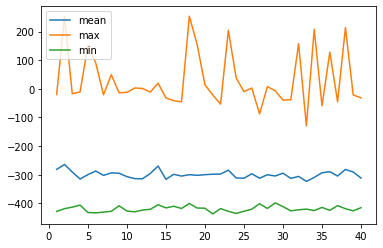

mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
      minDistToFood
   add
      -1.0
      -1.0
 - - - - 
mul
   mul
      actionScore
   

In [11]:
NUM_GEN = 20
POP_SIZE = 24
TREE_SIZE = 4

population, fitness = generationLoop()
for p in population:
    p.print_tree()
    print(" - - - - ")
print(fitness)

print(winsDict)

In [12]:
# args = readCommand(['--layout', 'smallClassic', '--pacman', 'GoWestAgent', '-t']) # Get game components based on input
gameLayout = layout.getLayout( 'smallClassic' )

ind = GPTree()
ind.random_tree(True, 2)
ind.print_tree()

pacman = MyGoWestAgent(ind)
# pacman.setTree(ind)

ghostType = loadAgent('RandomGhost', True)
ghosts = [ghostType( i+1 ) for i in range( 4 )]

import textDisplay
textDisplay.SLEEP_TIME = 0.1
gameDisplay = textDisplay.PacmanGraphics()

runGames(gameLayout, pacman, ghosts, gameDisplay, 3, False)

layout:  smallClassic
add
   mul
      0.5
      2.0
   sub
      distToPill
      1.0
%%%%%%%%%%%%%%%%%%%%
%......%G  G%......%
%.%%...%%  %%...%%.%
%.%o.%........%.o%.%
%.%%.%.%%%%%%.%.%%.%
%........<.........%
%%%%%%%%%%%%%%%%%%%%
Score: 0

%%%%%%%%%%%%%%%%%%%%
%......% GG %......%
%.%%...%%  %%...%%.%
%.%o.%........%.o%.%
%.%%.%.%%%%%%.%.%%.%
%.......> .........%
%%%%%%%%%%%%%%%%%%%%
Score: 9

%%%%%%%%%%%%%%%%%%%%
%......% GG %......%
%.%%...%%  %%...%%.%
%.%o.%........%.o%.%
%.%%.%.%%%%%%.%.%%.%
%......>  .........%
%%%%%%%%%%%%%%%%%%%%
Score: 18

%%%%%%%%%%%%%%%%%%%%
%......%G   %......%
%.%%...%% G%%...%%.%
%.%o.%........%.o%.%
%.%%.%.%%%%%%.%.%%.%
%.....>   .........%
%%%%%%%%%%%%%%%%%%%%
Score: 27

%%%%%%%%%%%%%%%%%%%%
%......% G  %......%
%.%%...%%  %%...%%.%
%.%o.%....G...%.o%.%
%.%%.%v%%%%%%.%.%%.%
%.....    .........%
%%%%%%%%%%%%%%%%%%%%
Score: 36

%%%%%%%%%%%%%%%%%%%%
%......%  G %......%
%.%%...%%  %%...%%.%
%.%o.%v..G....%.o%.%
%.%%.% %%%%%%.%.%%.%
%.....    .........%

%%%%%%%%%%%%%%%%%%%%
%..G...%    %  ....%
%.%%...%% ^%%  .%%.%
%.%o.%  G     %.o%.%
%.%%.% %%%%%% %.%%.%
%...          .....%
%%%%%%%%%%%%%%%%%%%%
Score: 178

%%%%%%%%%%%%%%%%%%%%
%.G....%    %  ....%
%.%%...%%  %%  .%%.%
%.%o.% G  ^   %.o%.%
%.%%.% %%%%%% %.%%.%
%...          .....%
%%%%%%%%%%%%%%%%%%%%
Score: 177

%%%%%%%%%%%%%%%%%%%%
%G.....%    %  ....%
%.%%...%%  %%  .%%.%
%.%o.%G  >    %.o%.%
%.%%.% %%%%%% %.%%.%
%...          .....%
%%%%%%%%%%%%%%%%%%%%
Score: 176

%%%%%%%%%%%%%%%%%%%%
%......%    %  ....%
%G%%..G%%  %%  .%%.%
%.%o.%  >     %.o%.%
%.%%.% %%%%%% %.%%.%
%...          .....%
%%%%%%%%%%%%%%%%%%%%
Score: 175

%%%%%%%%%%%%%%%%%%%%
%.....G%    %  ....%
%.%%...%%  %%  .%%.%
%G%o.% >      %.o%.%
%.%%.% %%%%%% %.%%.%
%...          .....%
%%%%%%%%%%%%%%%%%%%%
Score: 174

%%%%%%%%%%%%%%%%%%%%
%....G.%    %  ....%
%.%%...%%  %%  .%%.%
%.%o.%>       %.o%.%
%G%%.% %%%%%% %.%%.%
%...          .....%
%%%%%%%%%%%%%%%%%%%%
Score: 173

%%%%%%%%%%%%%%%%%%%%
%...G..%    %  ....%
%.%%

%%%%%%%%%%%%%%%%%%%%
%      %    %  ....%
% %%   %%  %%  .%%.%
% %o %       G%.o%.%
% %% % %%%%%% %.%%.%
%   G<        .....%
%%%%%%%%%%%%%%%%%%%%
Score: 296

%%%%%%%%%%%%%%%%%%%%
%      %    %  ....%
% %%   %%  %%  .%%.%
% %o %        %.o%.%
% %% % %%%%%%G%.%%.%
%    G<       .....%
%%%%%%%%%%%%%%%%%%%%
Score: 295

%%%%%%%%%%%%%%%%%%%%
%      %    %  ....%
% %%   %%  %%  .%%.%
% %o %        %.o%.%
% %% %v%%%%%% %.%%.%
%     G      G.....%
%%%%%%%%%%%%%%%%%%%%
Score: 294

%%%%%%%%%%%%%%%%%%%%
%      %    %  ....%
% %%   %%  %%  .%%.%
% %o %v       %.o%.%
% %% % %%%%%% %.%%.%
%      G      G....%
%%%%%%%%%%%%%%%%%%%%
Score: 293

%%%%%%%%%%%%%%%%%%%%
%      %    %  ....%
% %%   %%  %%  .%%.%
% %o %        %.o%.%
% %% %^%%%%%% %.%%.%
%       G     .G...%
%%%%%%%%%%%%%%%%%%%%
Score: 292

%%%%%%%%%%%%%%%%%%%%
%      %    %  ....%
% %%   %%  %%  .%%.%
% %o %        %.o%.%
% %% % %%%%%% %G%%.%
%     ^  G    .....%
%%%%%%%%%%%%%%%%%%%%
Score: 291

%%%%%%%%%%%%%%%%%%%%
%      %    %  ....%
% %%

%%%%%%%%%%%%%%%%%%%%
%......%  G %......%
%.%%...%% G%%...%%.%
%.%o.% <......%.o%.%
%.%%.% %%%%%%.%.%%.%
%.....    .........%
%%%%%%%%%%%%%%%%%%%%
Score: 54

%%%%%%%%%%%%%%%%%%%%
%......%  G %......%
%.%%...%% G%%...%%.%
%.%o.%  <.....%.o%.%
%.%%.% %%%%%%.%.%%.%
%.....    .........%
%%%%%%%%%%%%%%%%%%%%
Score: 63

%%%%%%%%%%%%%%%%%%%%
%......%   G%......%
%.%%...%%  %%...%%.%
%.%o.%   <G...%.o%.%
%.%%.% %%%%%%.%.%%.%
%.....    .........%
%%%%%%%%%%%%%%%%%%%%
Score: 72

%%%%%%%%%%%%%%%%%%%%
%......%   G%......%
%.%%...%%  %%...%%.%
%.%o.%    G...%.o%.%
%.%%.% %%%%%%.%.%%.%
%.....    .........%
%%%%%%%%%%%%%%%%%%%%
Score: -419

Pacman died! Score: -419
%%%%%%%%%%%%%%%%%%%%
%......%G  G%......%
%.%%...%%  %%...%%.%
%.%o.%........%.o%.%
%.%%.%.%%%%%%.%.%%.%
%........<.........%
%%%%%%%%%%%%%%%%%%%%
Score: 0

%%%%%%%%%%%%%%%%%%%%
%......% GG %......%
%.%%...%%  %%...%%.%
%.%o.%........%.o%.%
%.%%.%.%%%%%%.%.%%.%
%.......> .........%
%%%%%%%%%%%%%%%%%%%%
Score: 9

%%%%%%%%%%%%%%%%%%%%
%.....